In this document, we will demonstrate how to use the provided supporting function to read all the data from one test and apply basic data preprocessing.

## Read data using the supporting function

In utility.py, we provide a supporting function that reads all the data (six csv files) from the folder of one test, and create a aggregated dataframe to store all the data. To use this function, you need to specify the path of the folder of one test. Below is a demonstration how to read all the data from one test in folder `projects\maintenance_industry_4_2024\dataset\training_data\20240105_164214` and create a dataframe.

In [16]:
from utility import read_all_csvs_one_test
import pandas as pd

# Specify path to the dictionary.
base_dictionary = '../../dataset/training_data/'
dictionary_name = '20240105_164214'
path = base_dictionary + dictionary_name

# Read the data.
df_data = read_all_csvs_one_test(path, dictionary_name)
df_data["data_motor_1_label"].value_counts()

0    3652
Name: data_motor_1_label, dtype: int64

## Read all the data and visualize them

Below is a demonstration of how to read all the data and visualize them.

20240105_164214: 0    Robot not moving, just starting up.
Name: Description, dtype: object



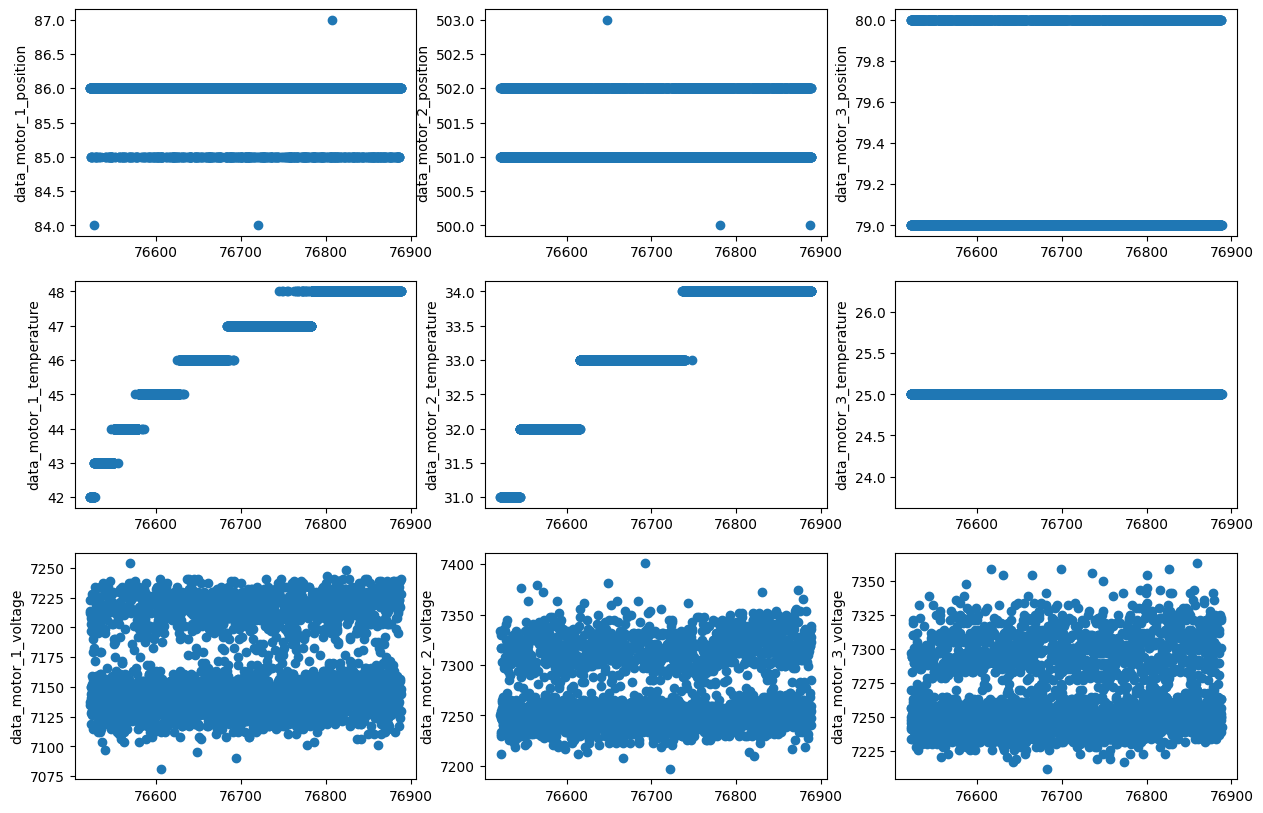

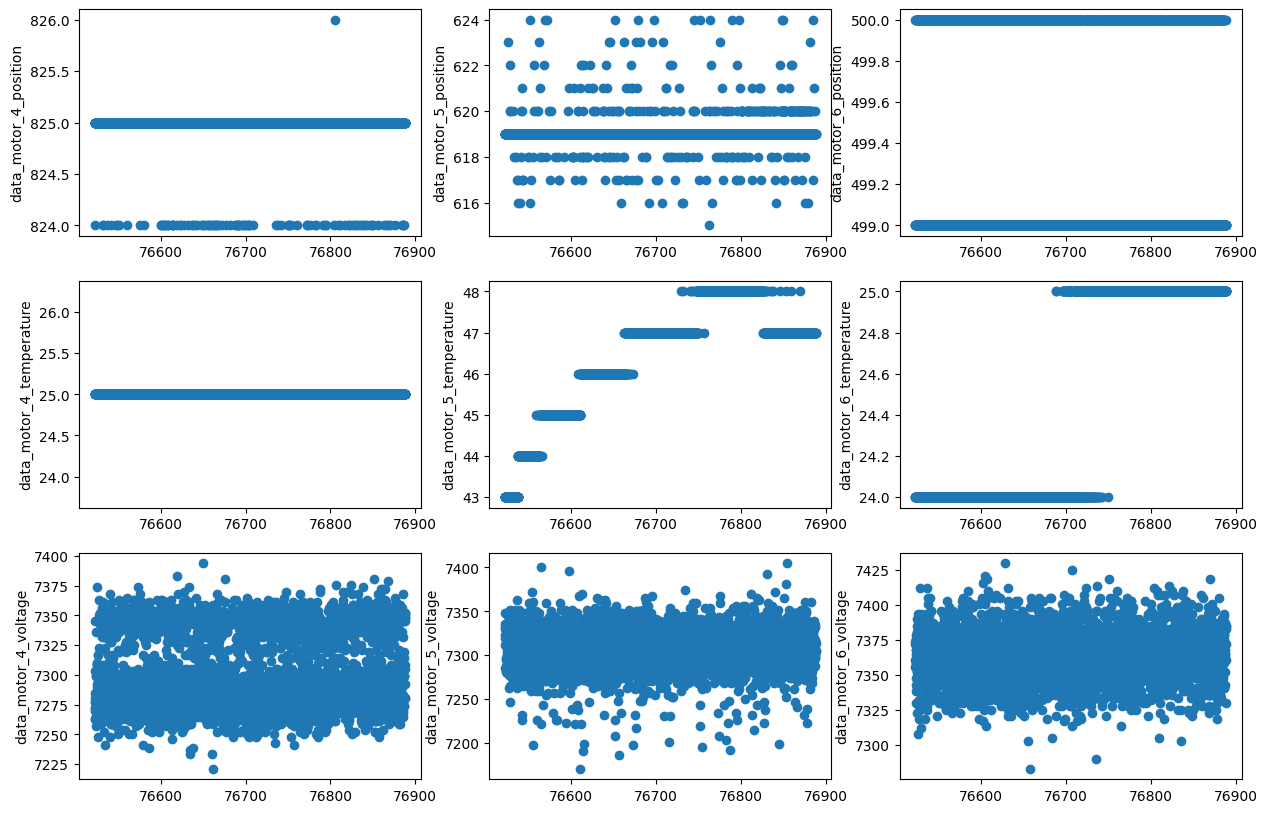

20240105_165300: 1    Not moving. Then perform a pick-up and place o...
Name: Description, dtype: object



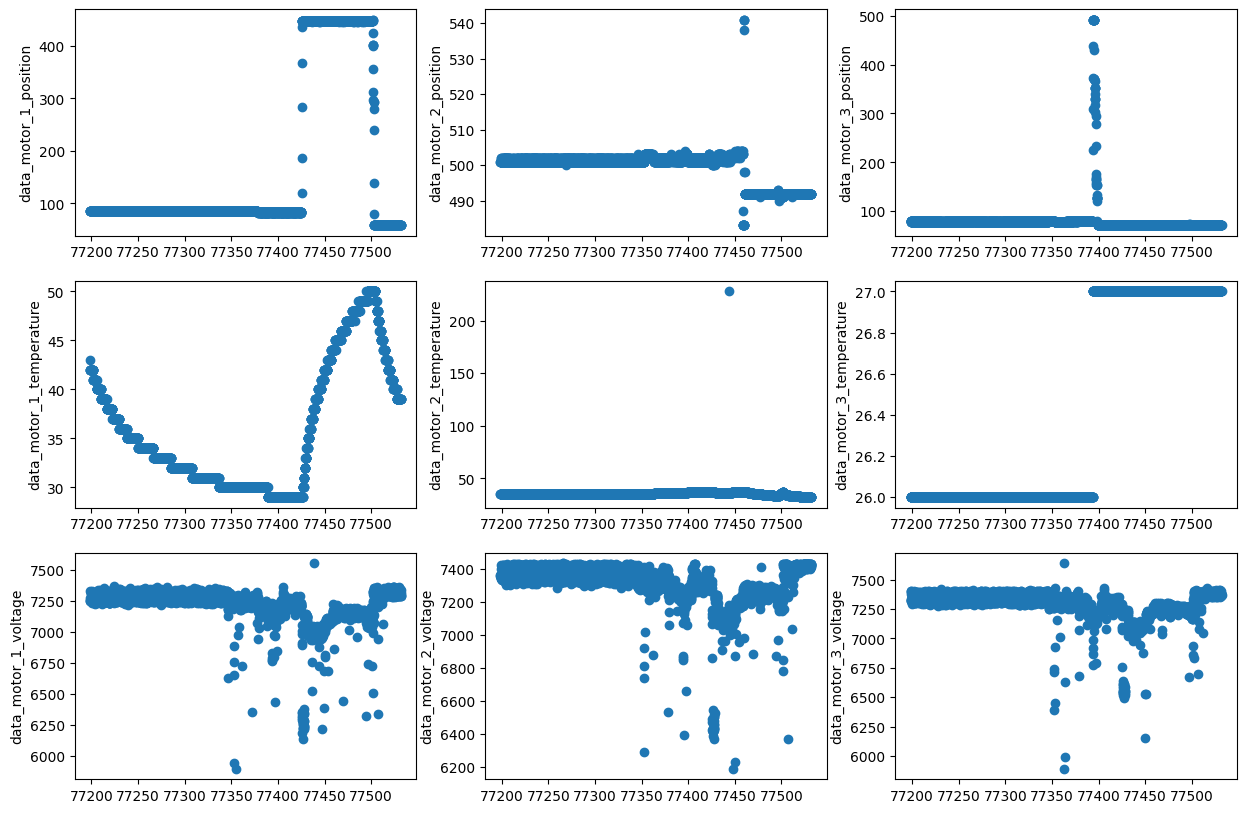

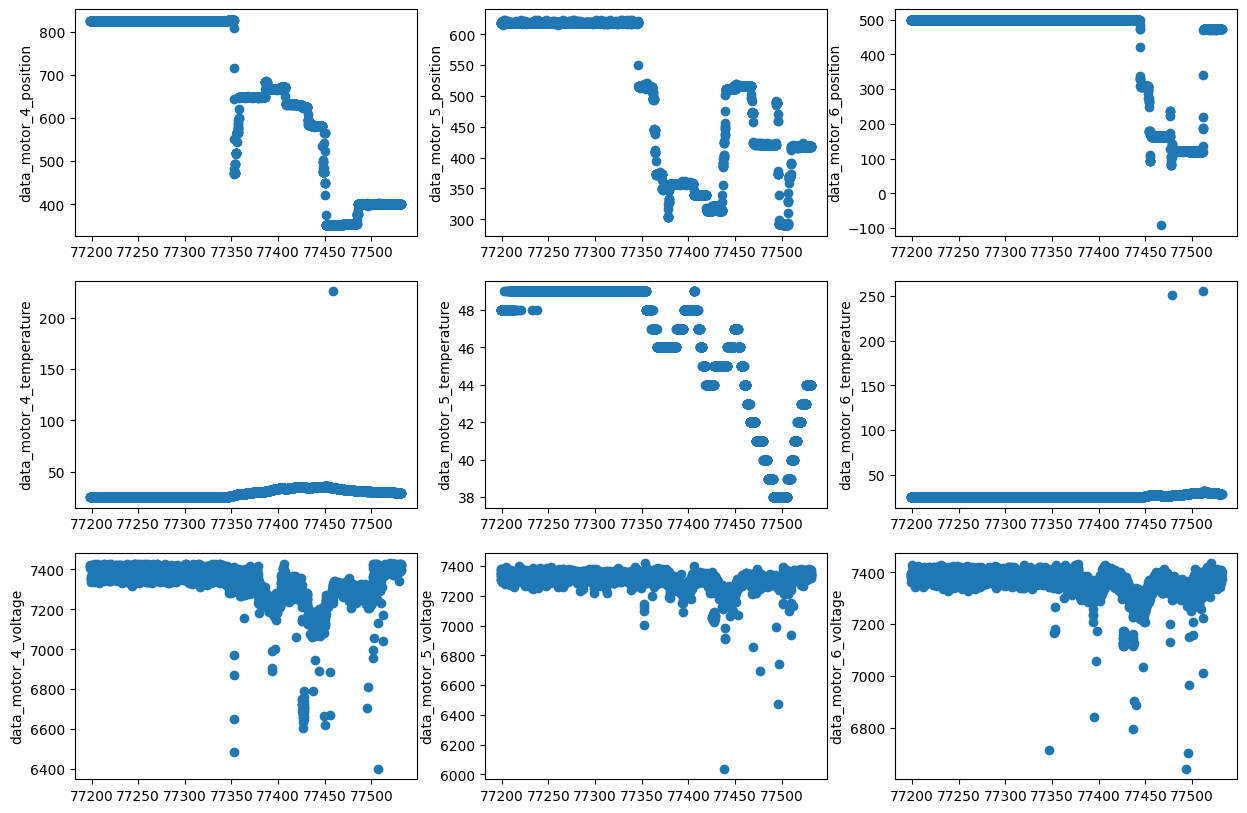

20240105_165972: 2    Not moving. After the operation.
Name: Description, dtype: object



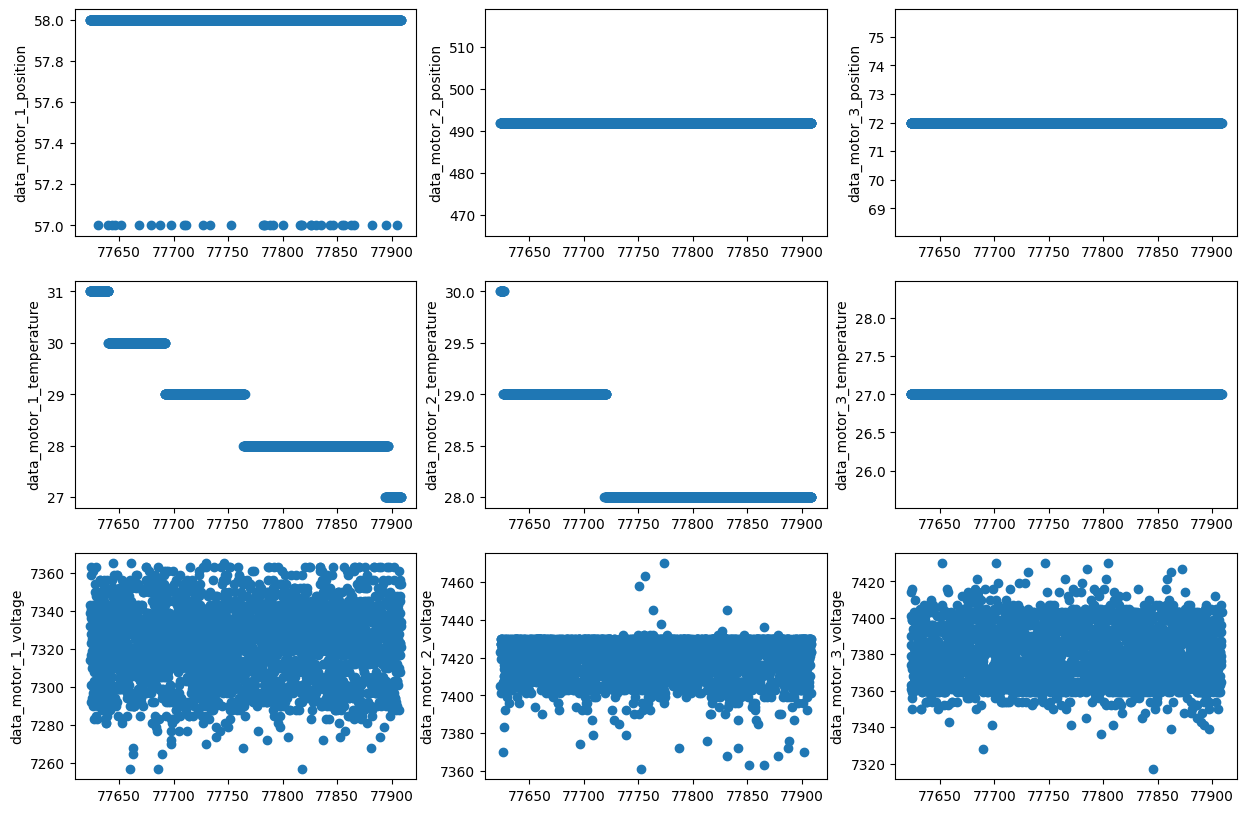

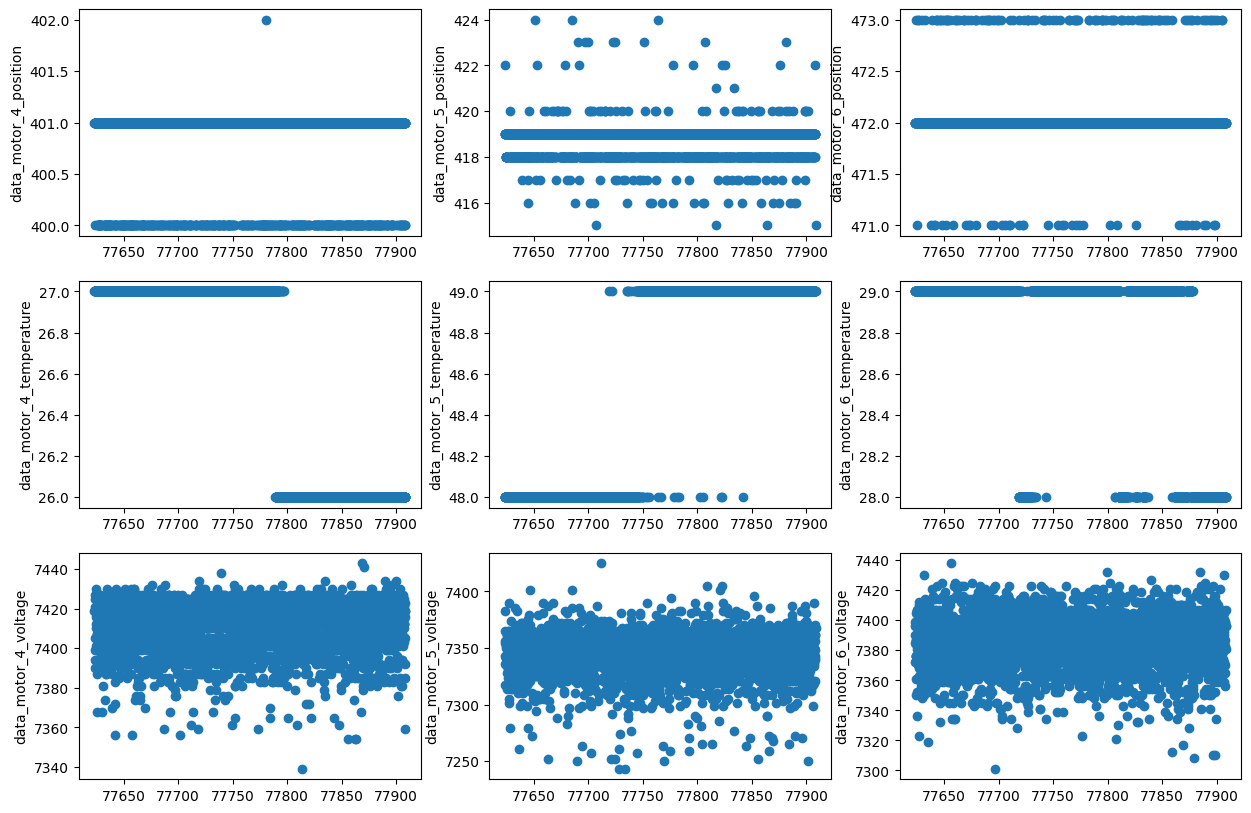

20240320_152031: 3    Robot not moving, just starting up.
Name: Description, dtype: object



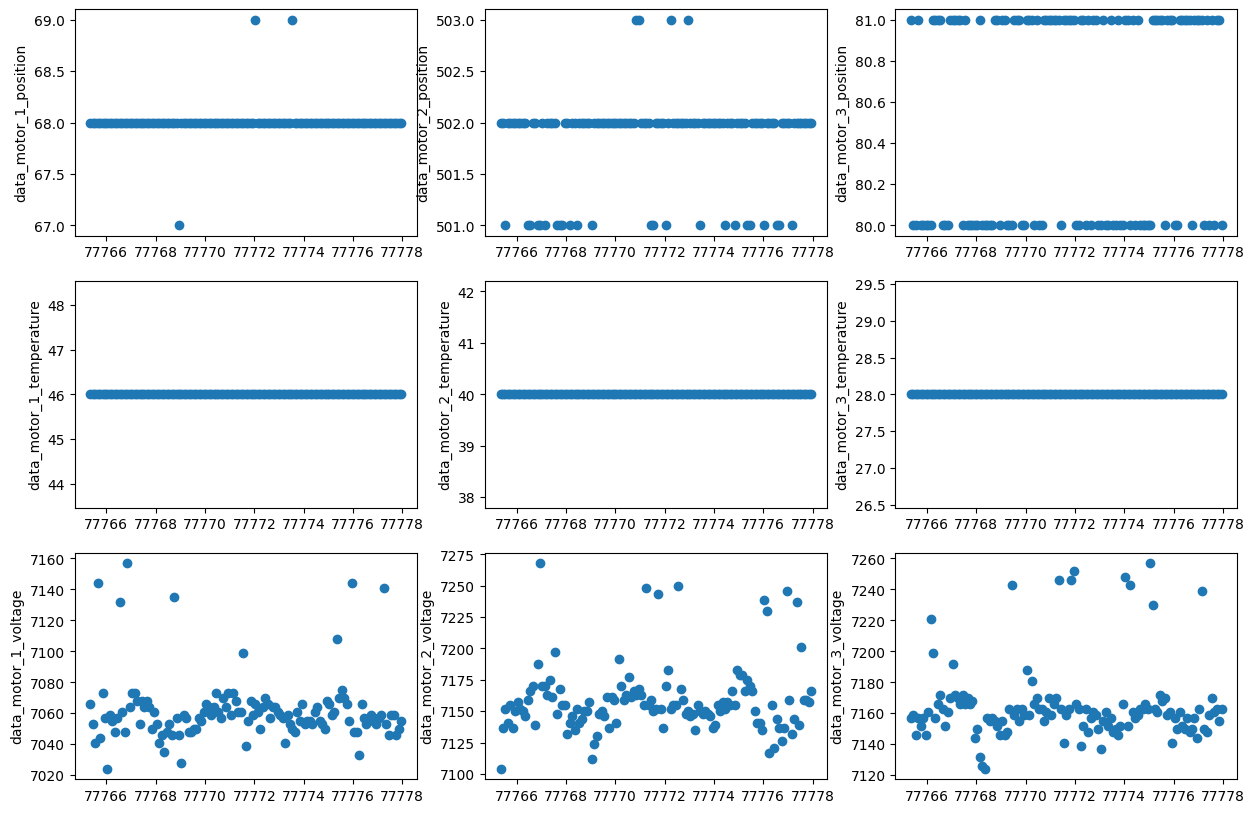

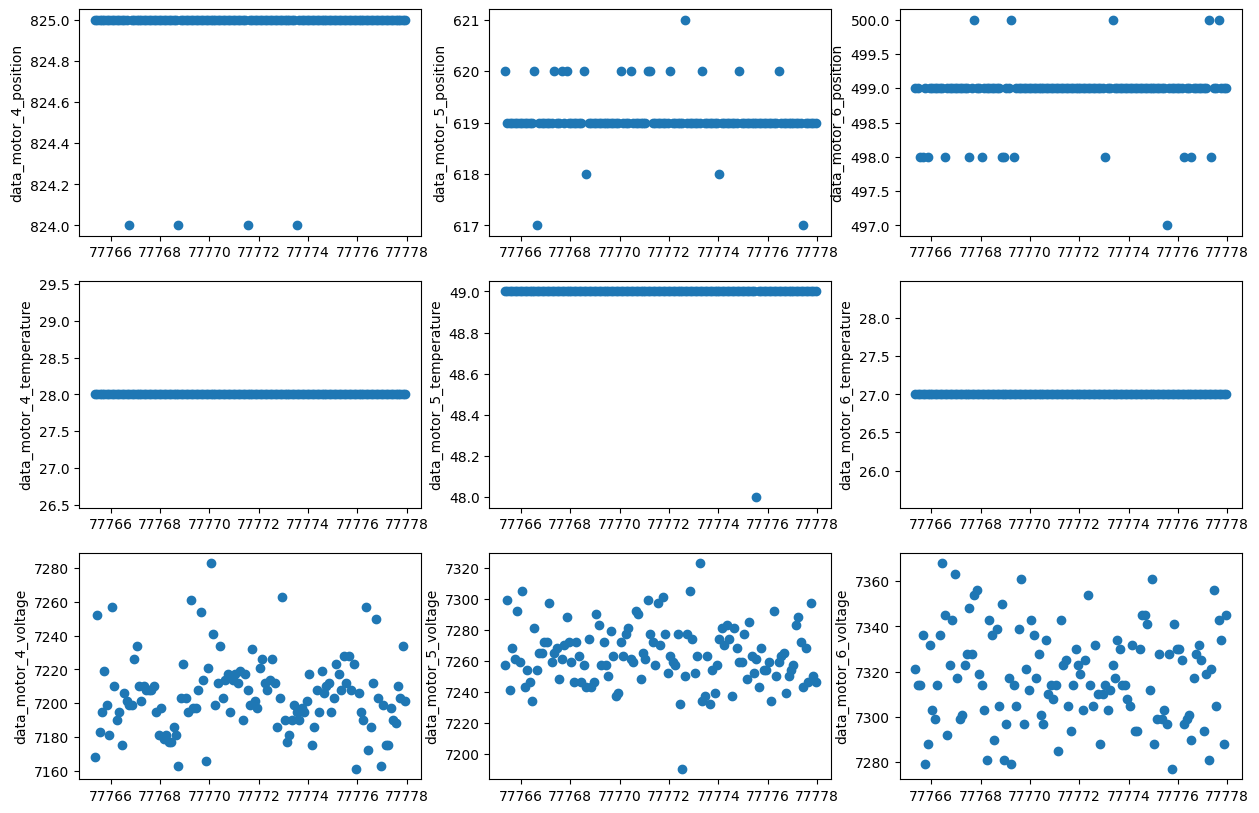

20240320_153841: 4    Not moving. Move motor 6 -> motor 1 sequentially.
Name: Description, dtype: object



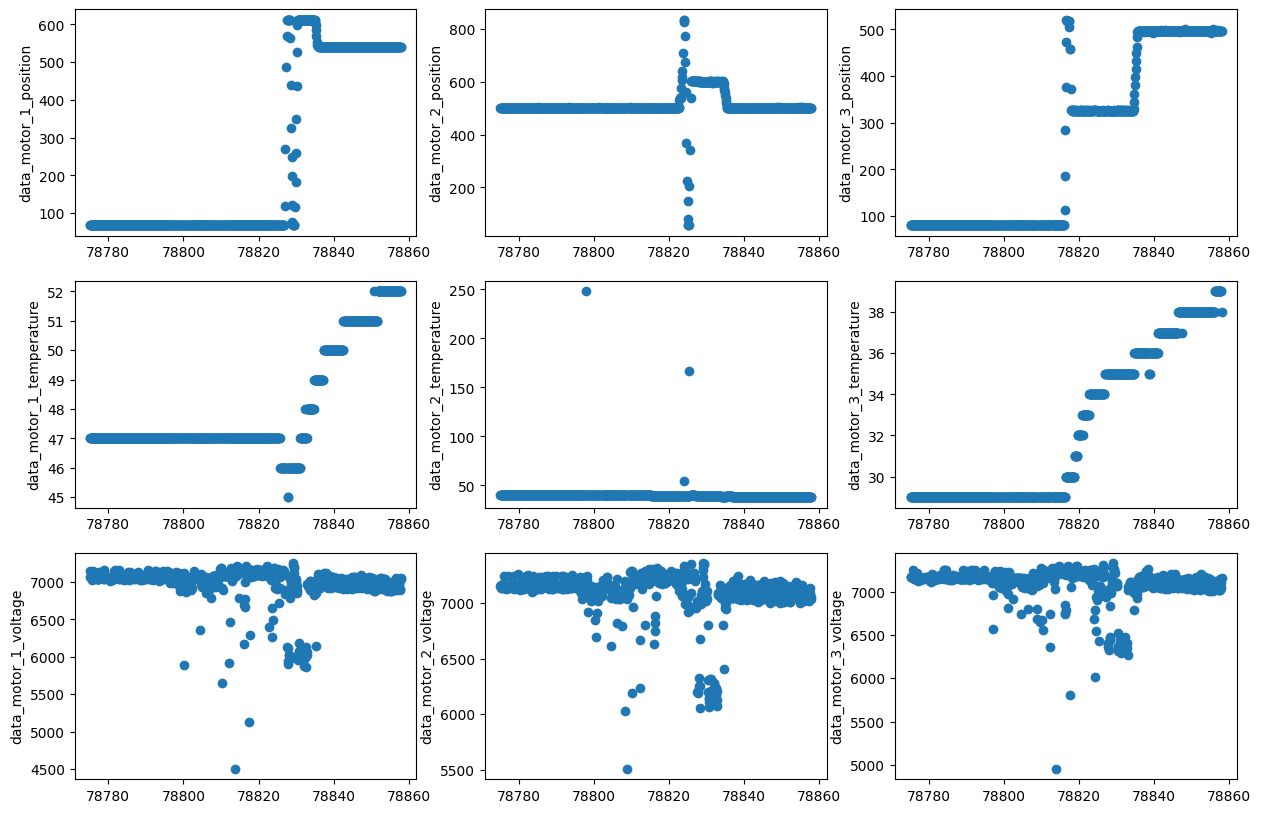

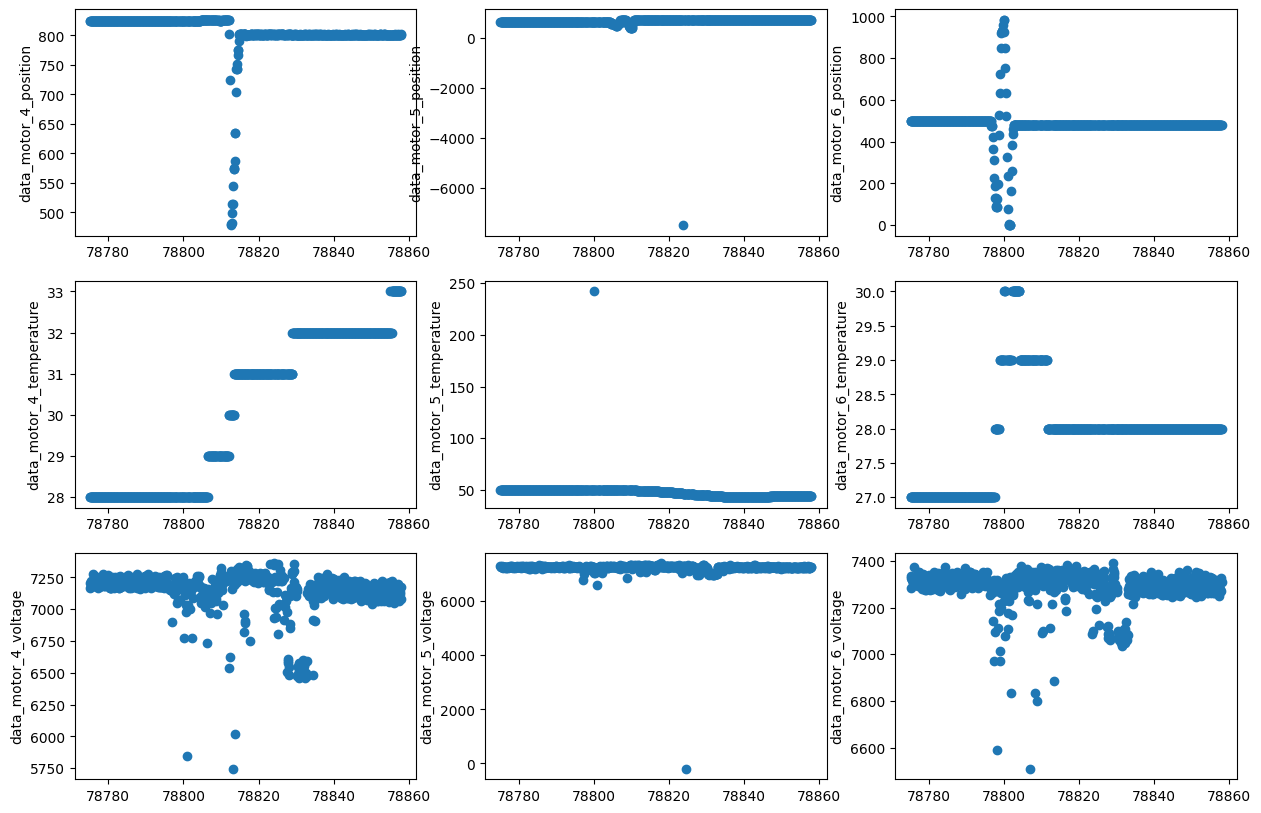

20240320_155664: 5    Robot not moving.
Name: Description, dtype: object



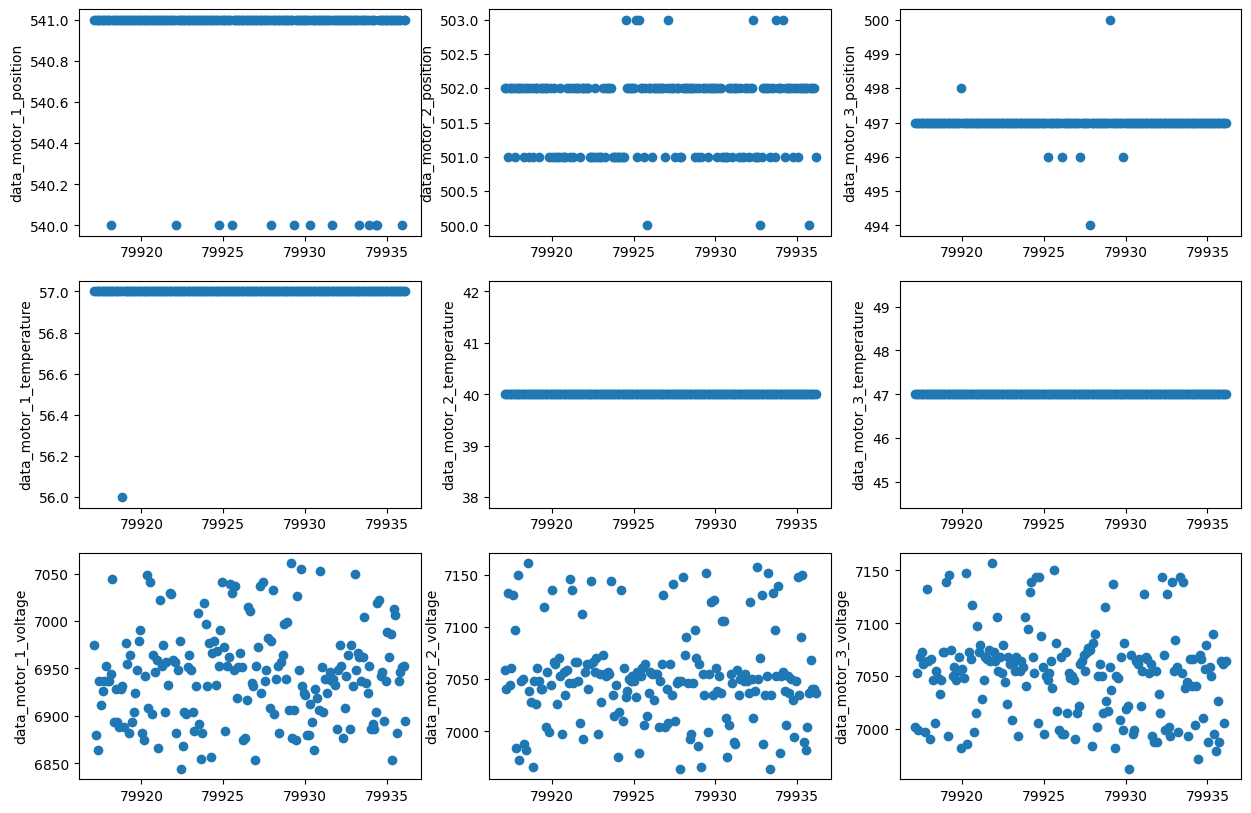

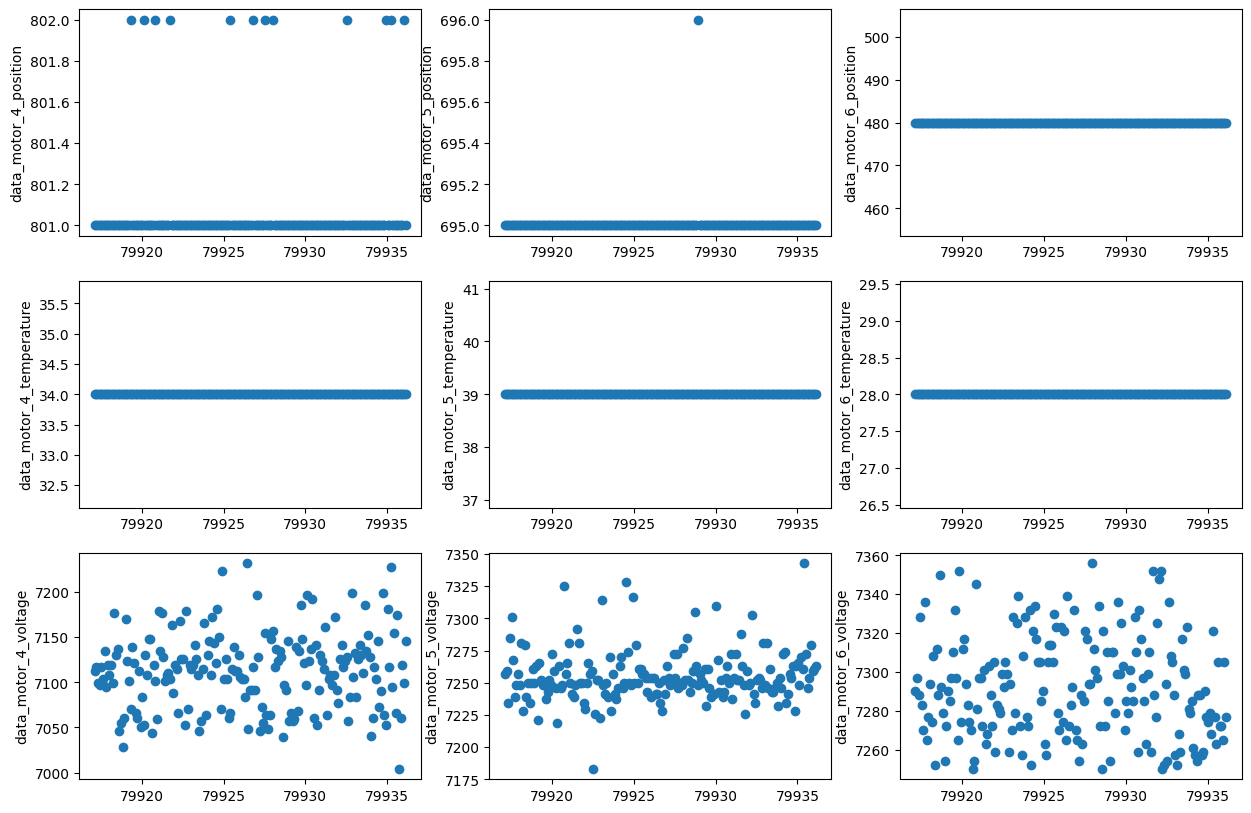

20240321_122650: 6    Try to move to pick up an item from second flo...
Name: Description, dtype: object



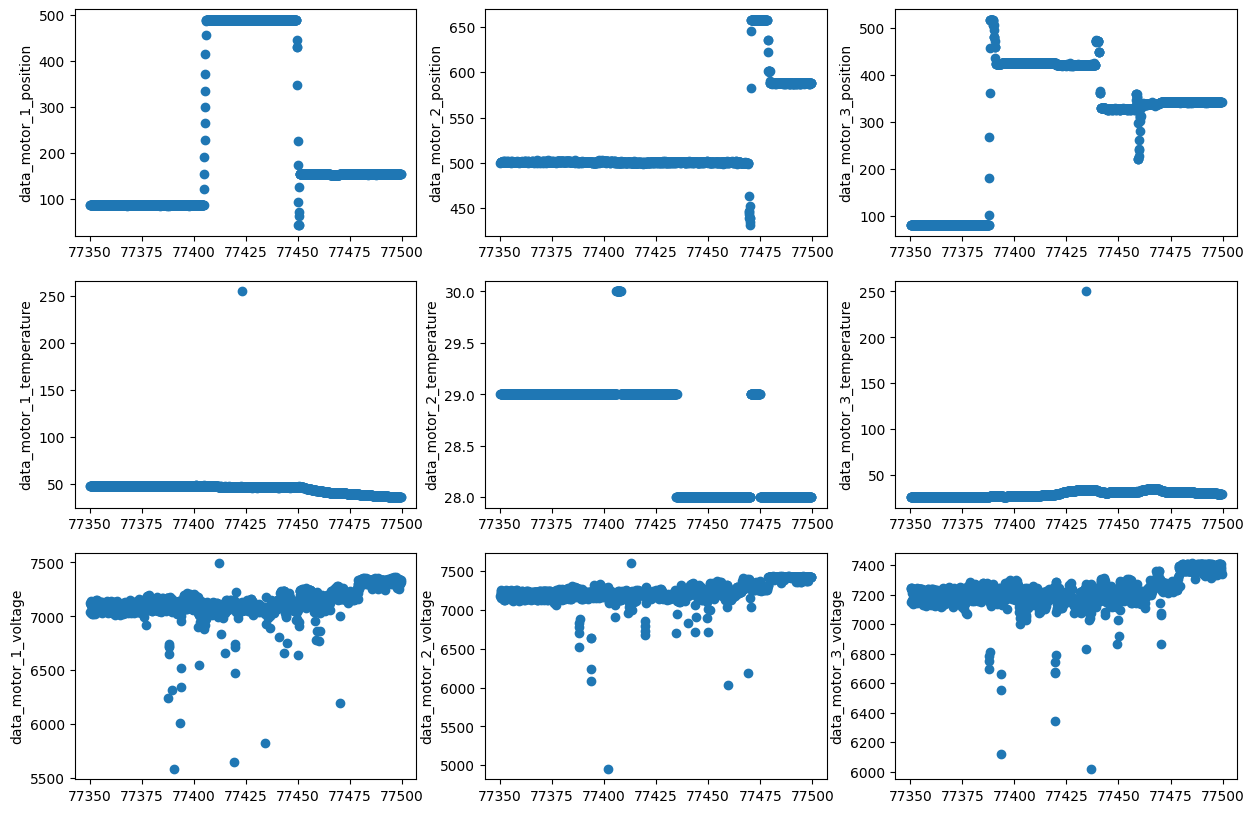

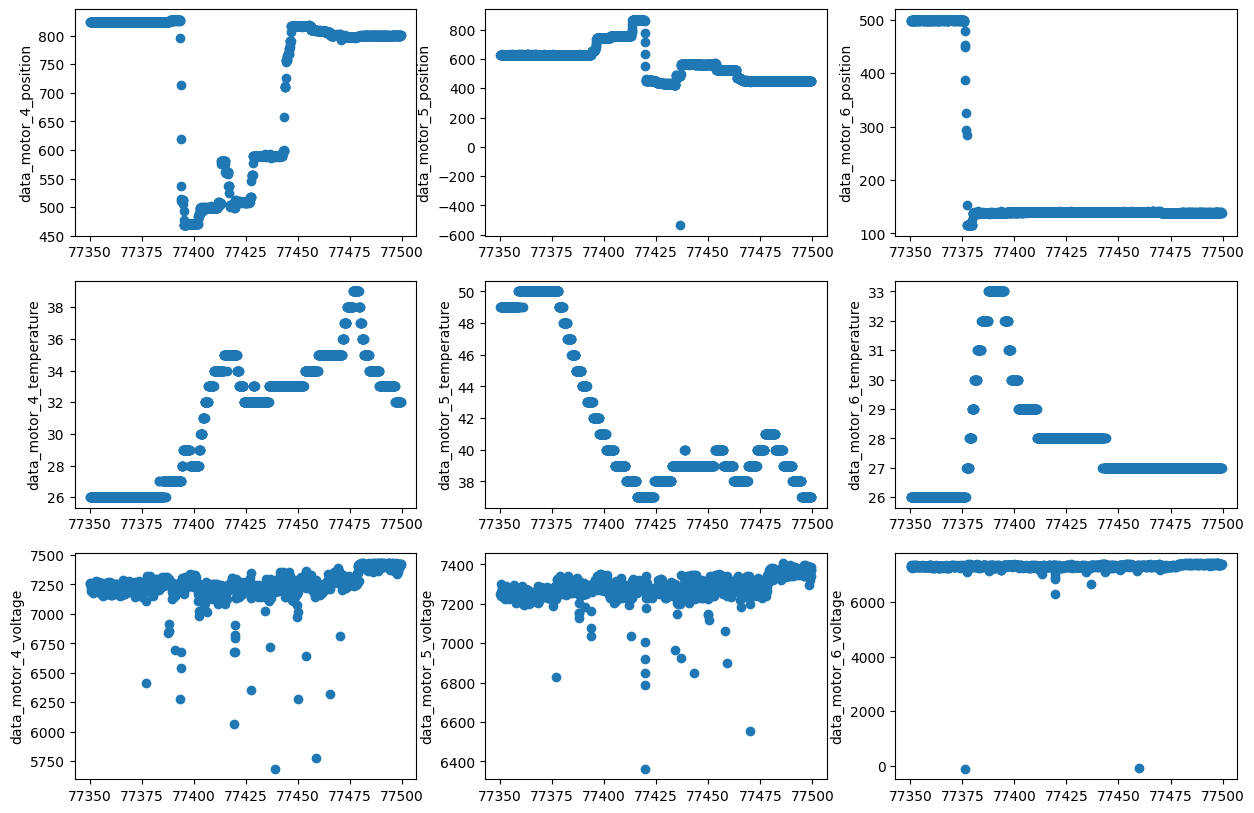

20240325_135213: 7    Robot not moving, just starting up.
Name: Description, dtype: object



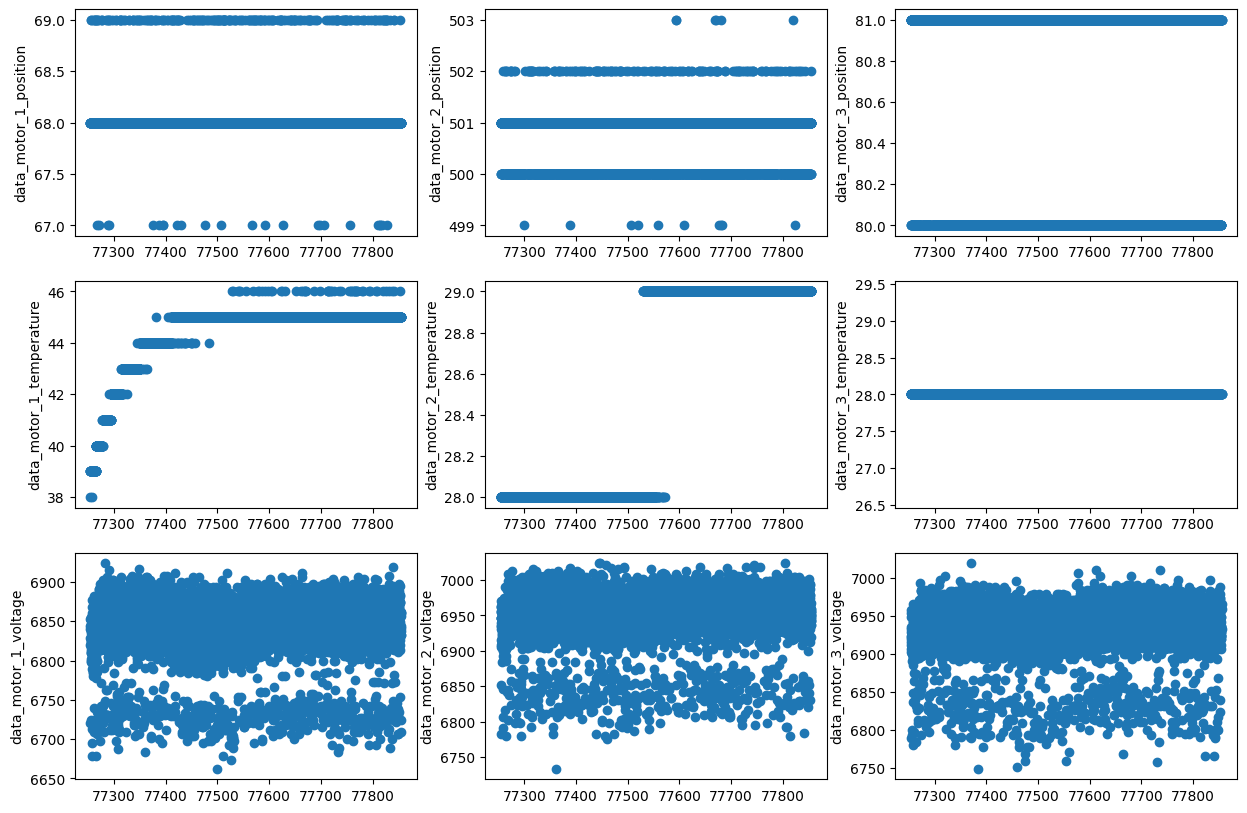

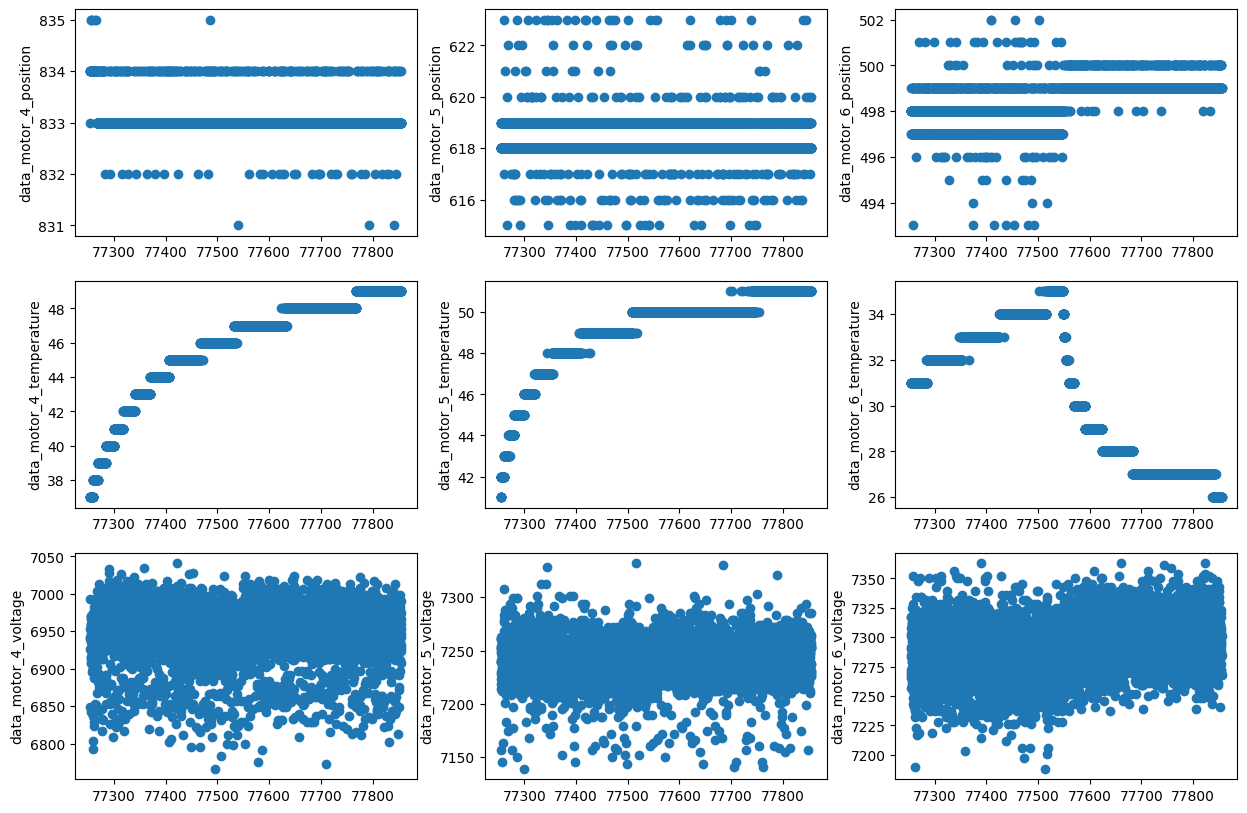

20240325_152902: 8    Not moving. Then perform a pick-up and place o...
Name: Description, dtype: object



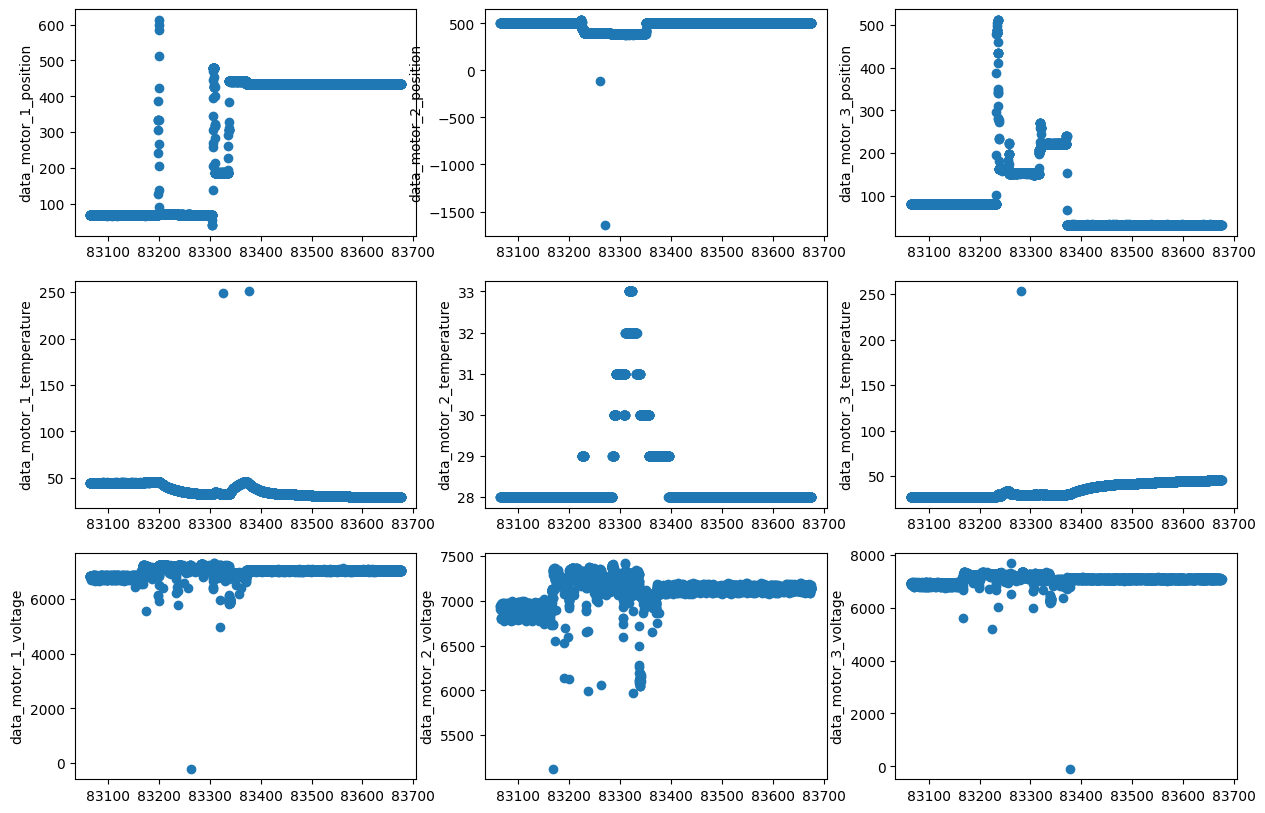

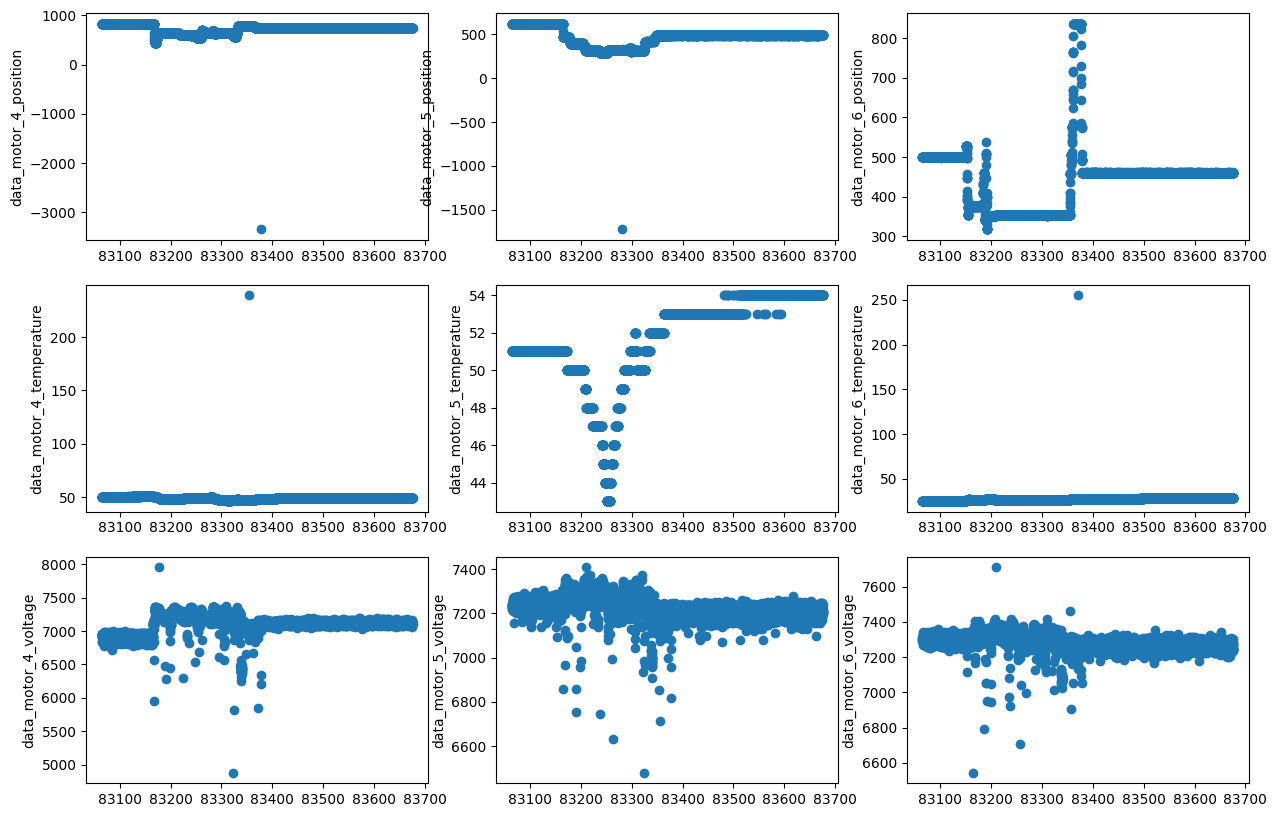

20240325_155003: 9    Starting position: Straigt. Perform two operat...
Name: Description, dtype: object



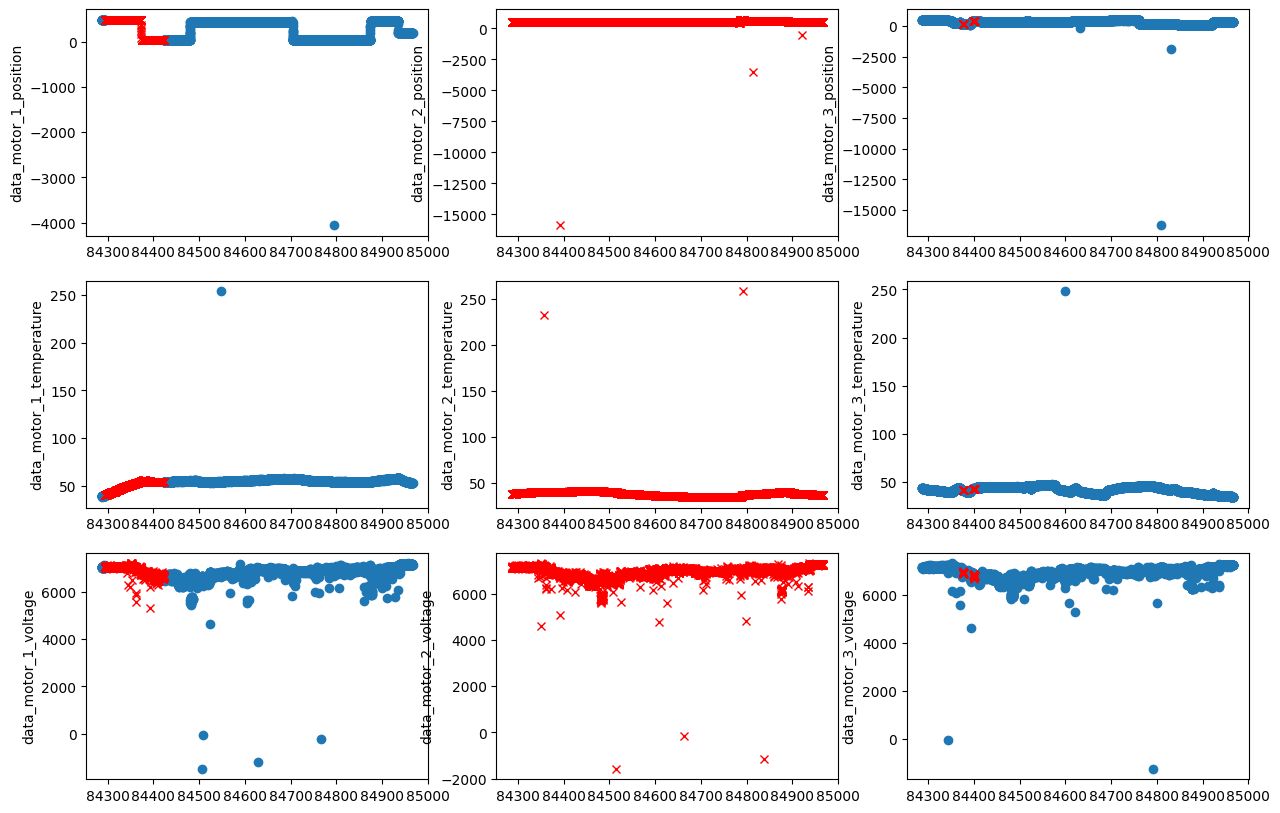

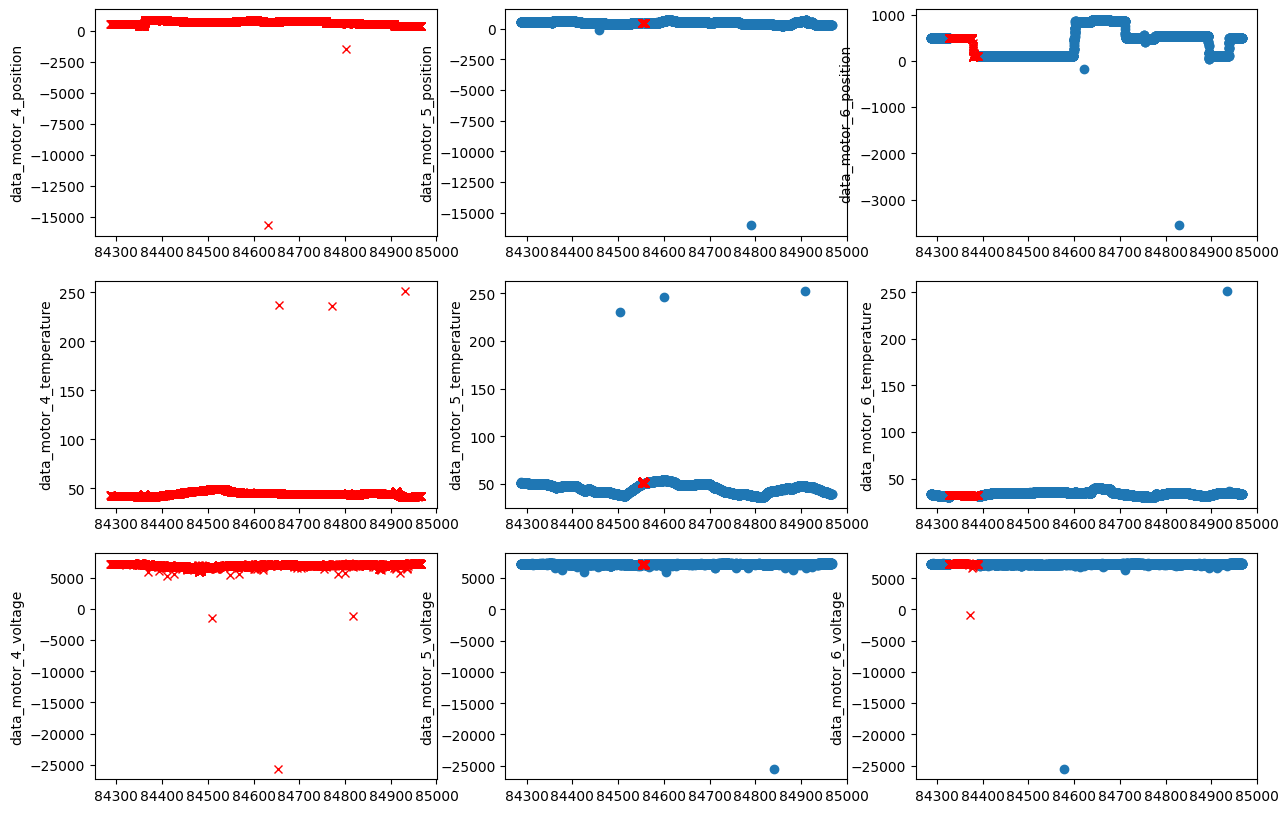

In [18]:
from utility import read_all_test_data_from_path

# Define the path to the folder 'collected_data'
base_dictionary = '../../dataset/training_data/'
# Read all the data
df_data = read_all_test_data_from_path(base_dictionary)


All the readed data will be stored in `df_data`. Each column's name tells the data is from which performance metric of which motor, and the last column specifies the test condition.

In [21]:
df_data.head()

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31135 entries, 0 to 31134
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time                      31135 non-null  float64
 1   data_motor_1_position     31135 non-null  int64  
 2   data_motor_1_temperature  31135 non-null  int64  
 3   data_motor_1_voltage      31135 non-null  int64  
 4   data_motor_1_label        31135 non-null  int64  
 5   data_motor_2_position     31135 non-null  int64  
 6   data_motor_2_temperature  31135 non-null  int64  
 7   data_motor_2_voltage      31135 non-null  int64  
 8   data_motor_2_label        31135 non-null  int64  
 9   data_motor_3_position     31135 non-null  int64  
 10  data_motor_3_temperature  31135 non-null  int64  
 11  data_motor_3_voltage      31135 non-null  int64  
 12  data_motor_3_label        31135 non-null  int64  
 13  data_motor_4_position     31135 non-null  int64  
 14  data_m

## Customize data preprocessing

It can be seen from the graphs above, there are some noise and outliers in the original data. To apply data preprocessing during the reading process, you can write a function to preprocess the data. This function needs to take as input a dataframe of the original csv file, apply the preprocessing, and return the preprocessed dataframe. Then, you can pass the handle of this function to the `read_all_csvs_one_test` function.

Below, we show a demo of removing outliers based on a pre-defined validity range. It can be seen that after the preprocessing, the outliers are removed.

20240105_164214: 0    Robot not moving, just starting up.
Name: Description, dtype: object



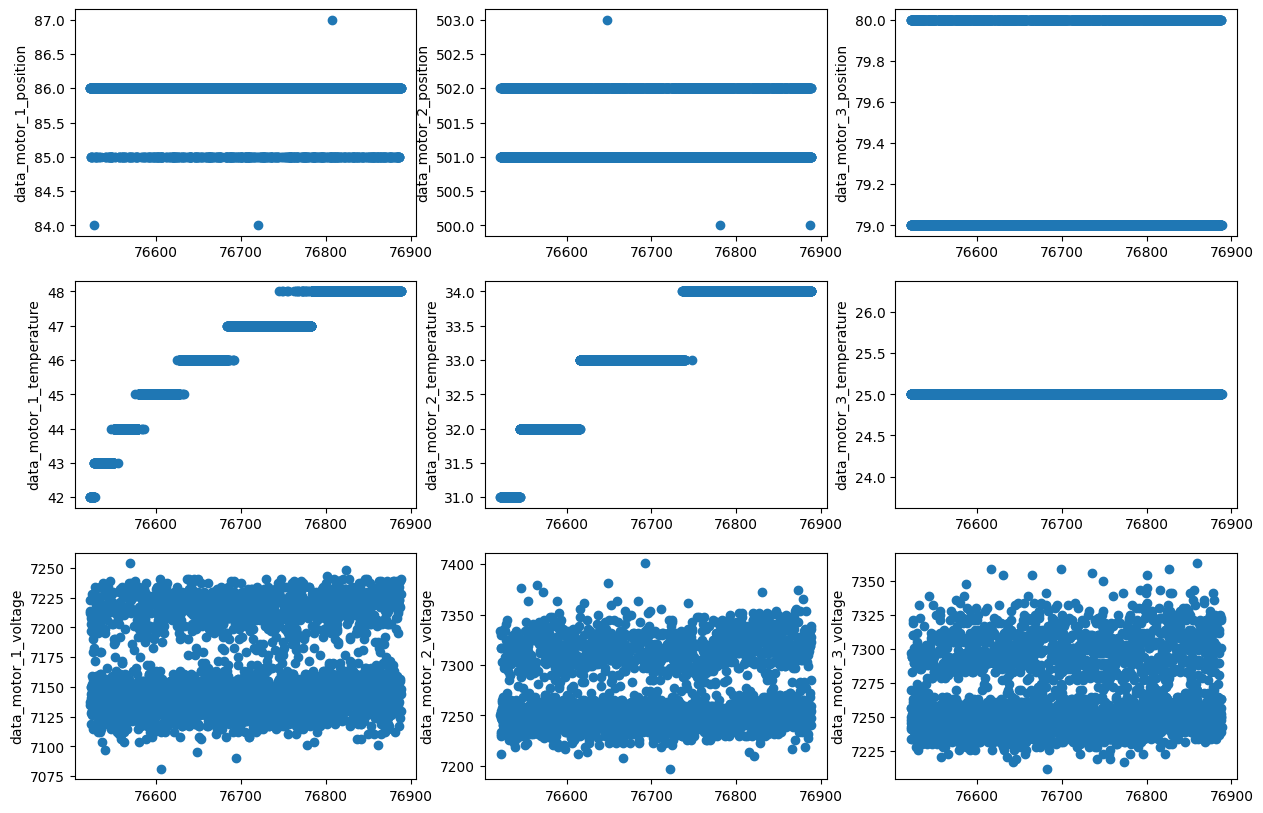

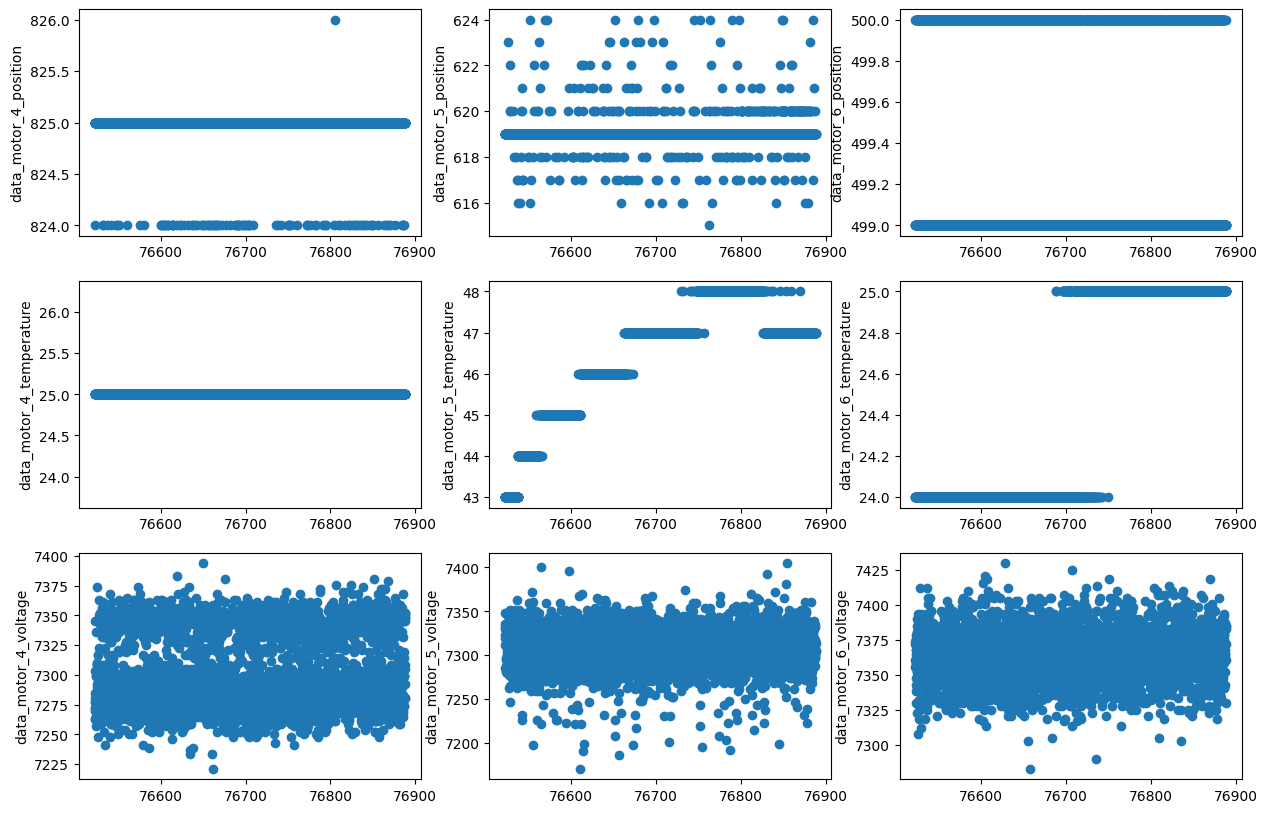

20240105_165300: 1    Not moving. Then perform a pick-up and place o...
Name: Description, dtype: object



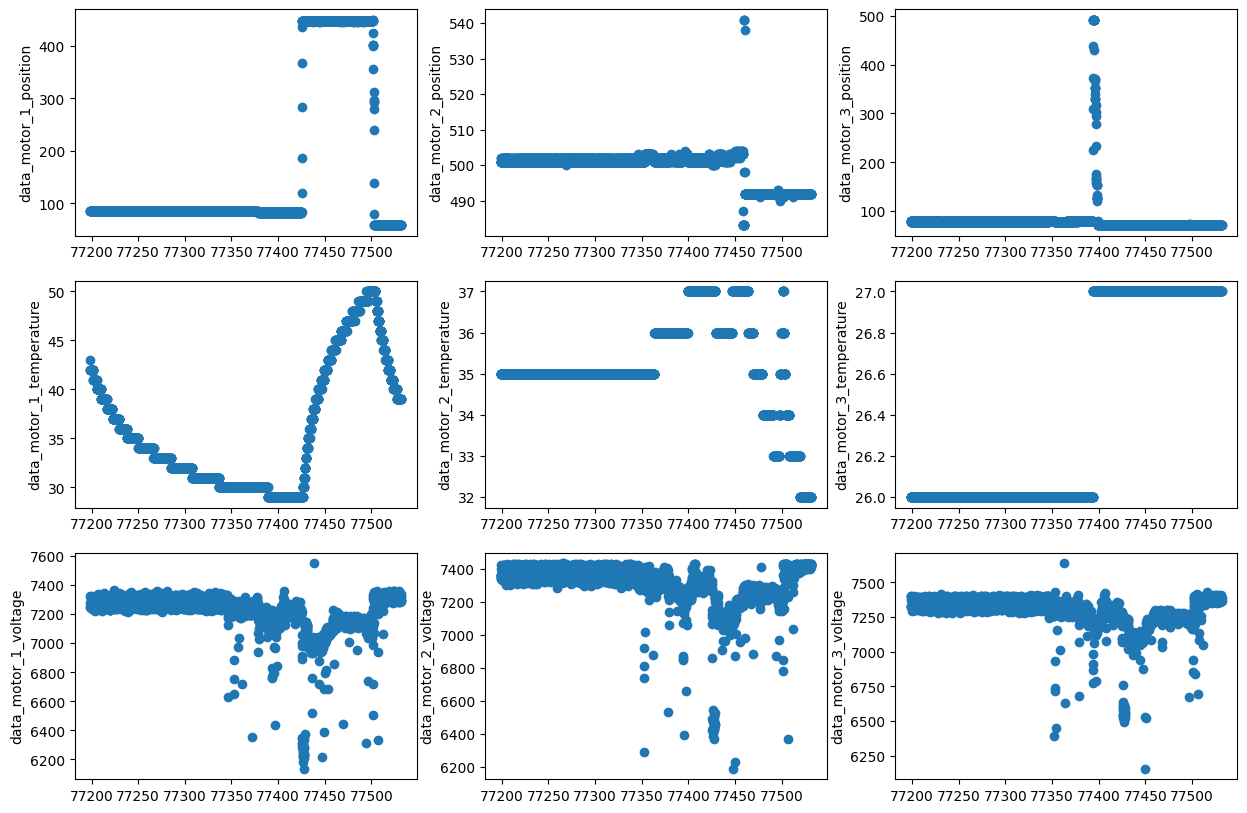

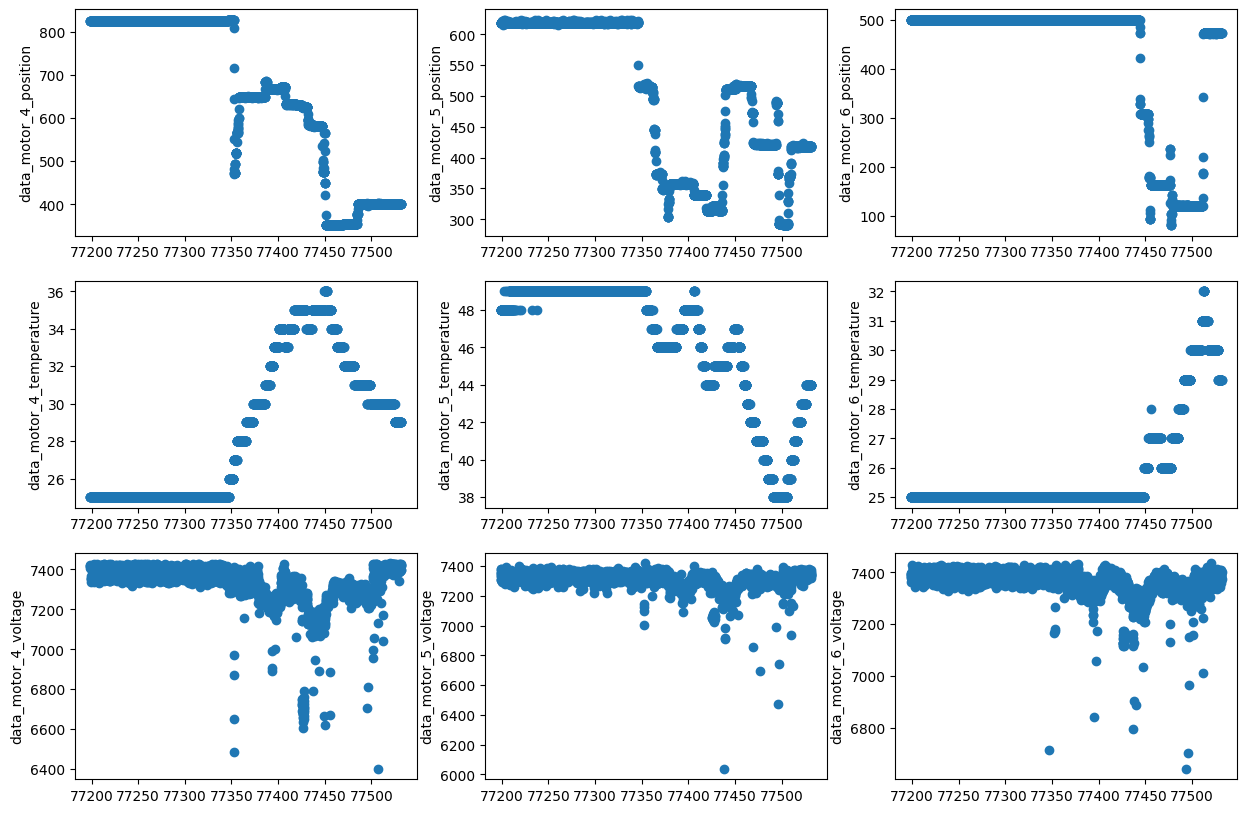

20240105_165972: 2    Not moving. After the operation.
Name: Description, dtype: object



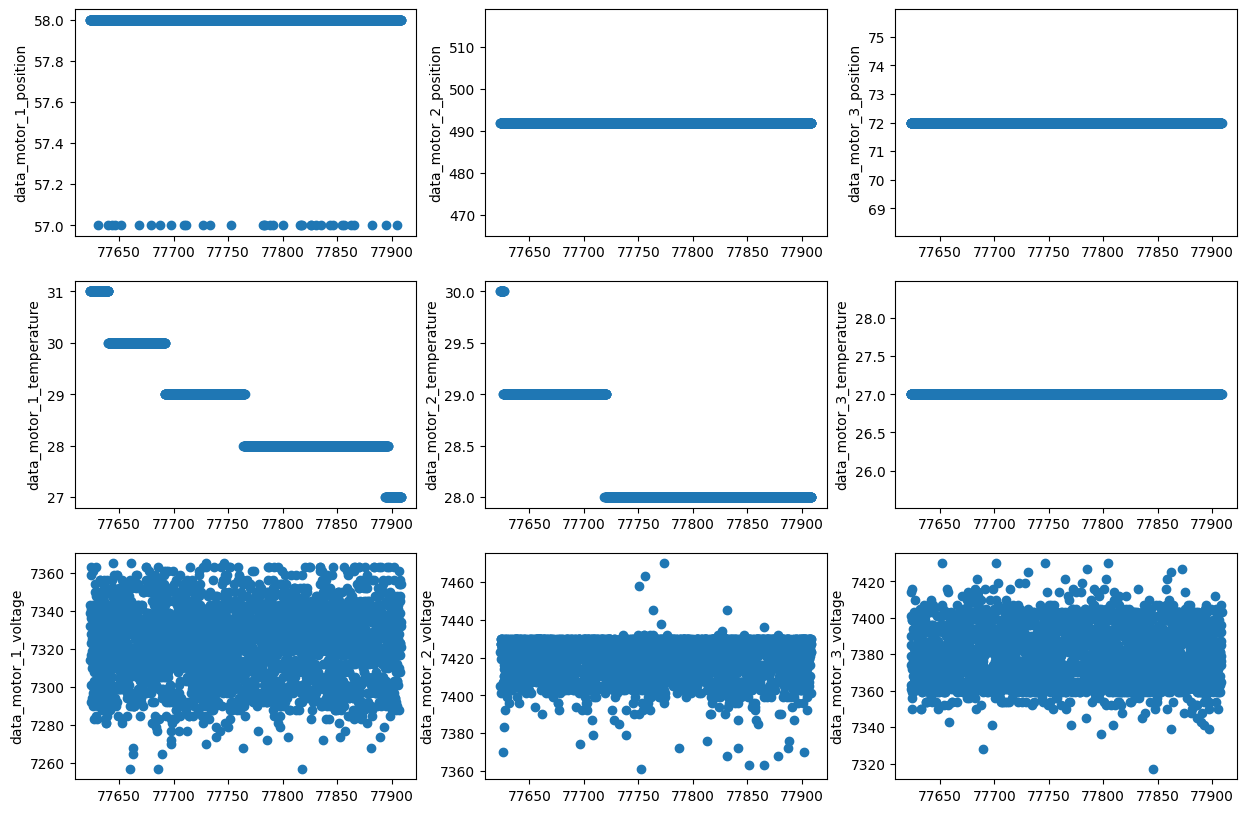

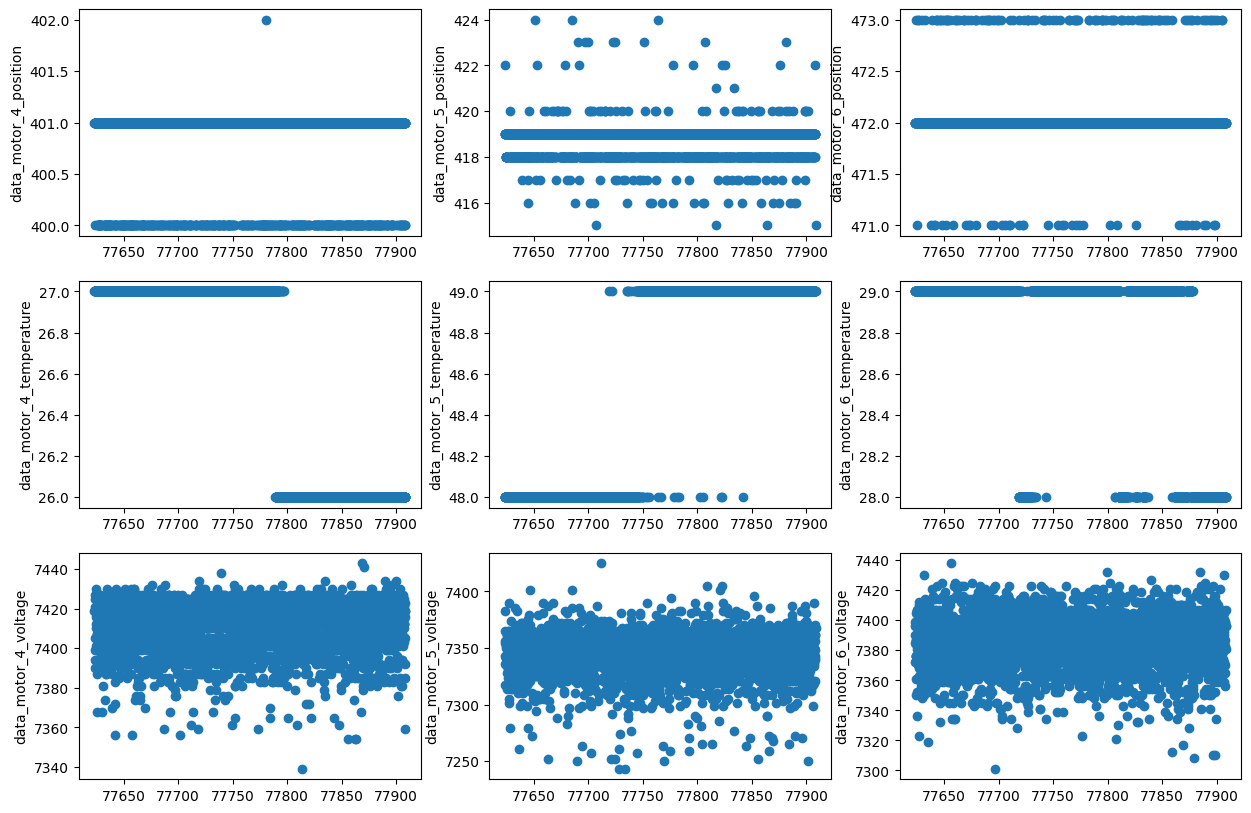

20240320_152031: 3    Robot not moving, just starting up.
Name: Description, dtype: object



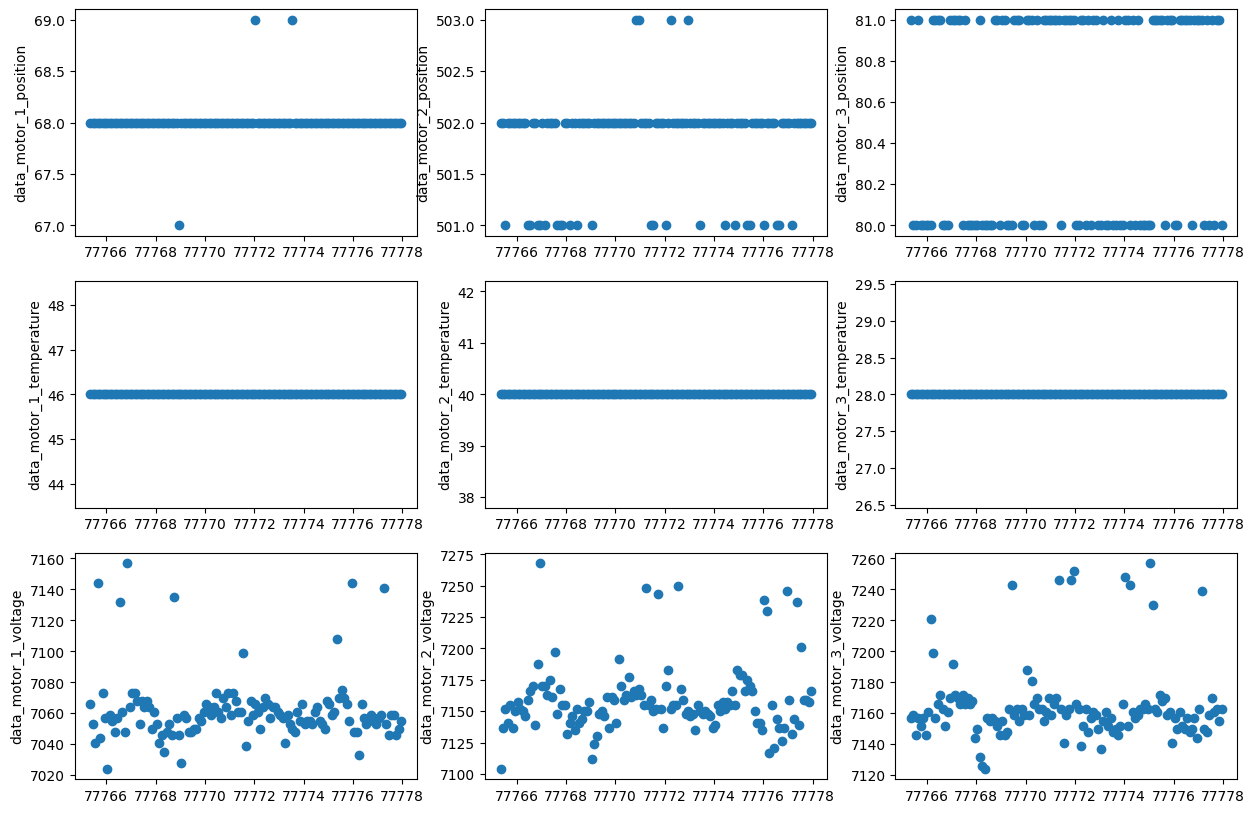

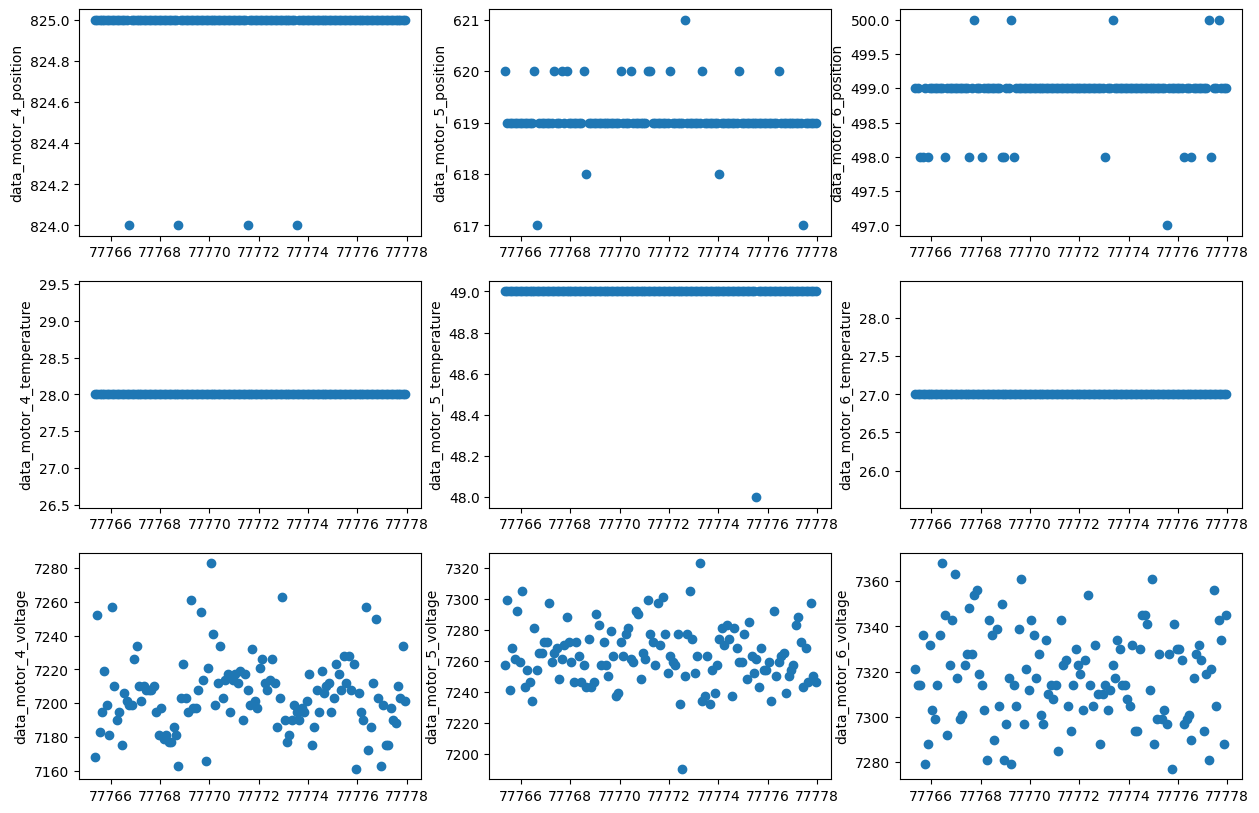

20240320_153841: 4    Not moving. Move motor 6 -> motor 1 sequentially.
Name: Description, dtype: object



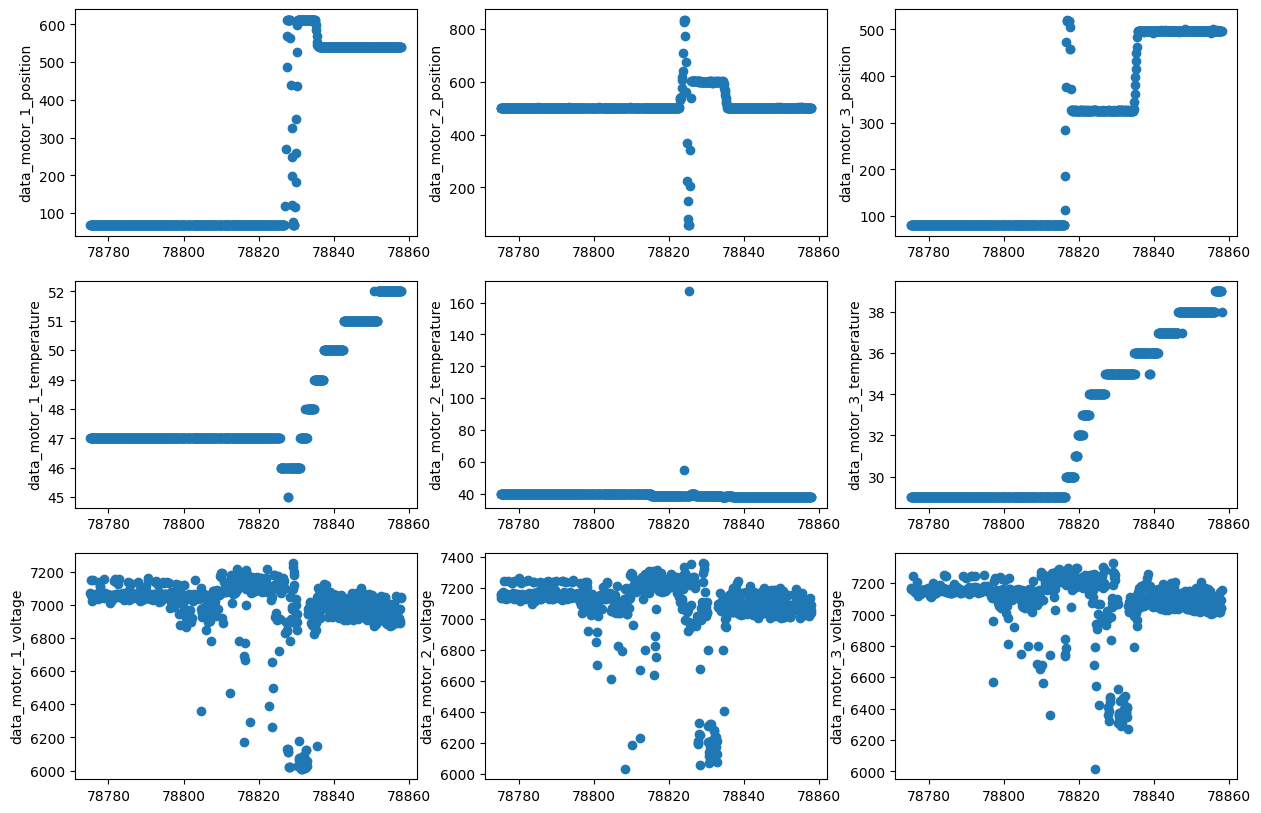

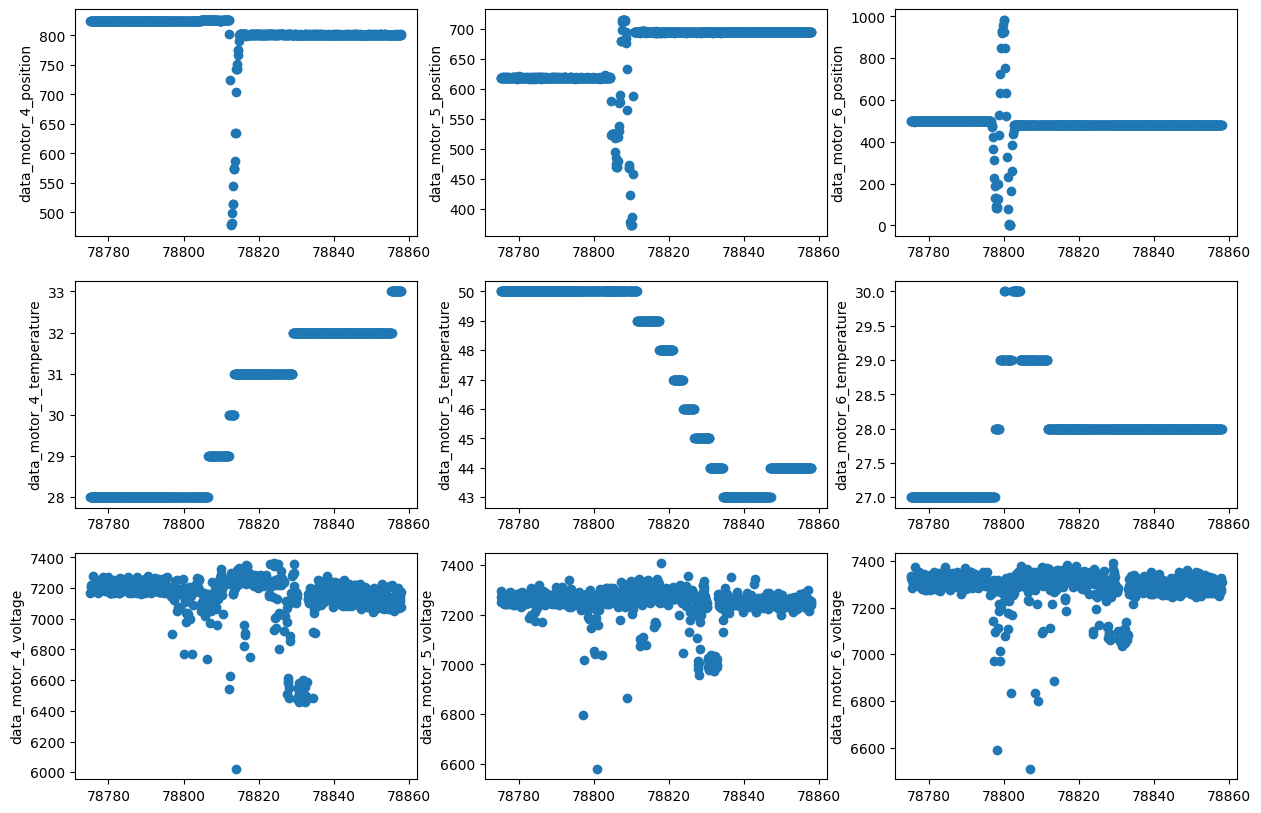

20240320_155664: 5    Robot not moving.
Name: Description, dtype: object



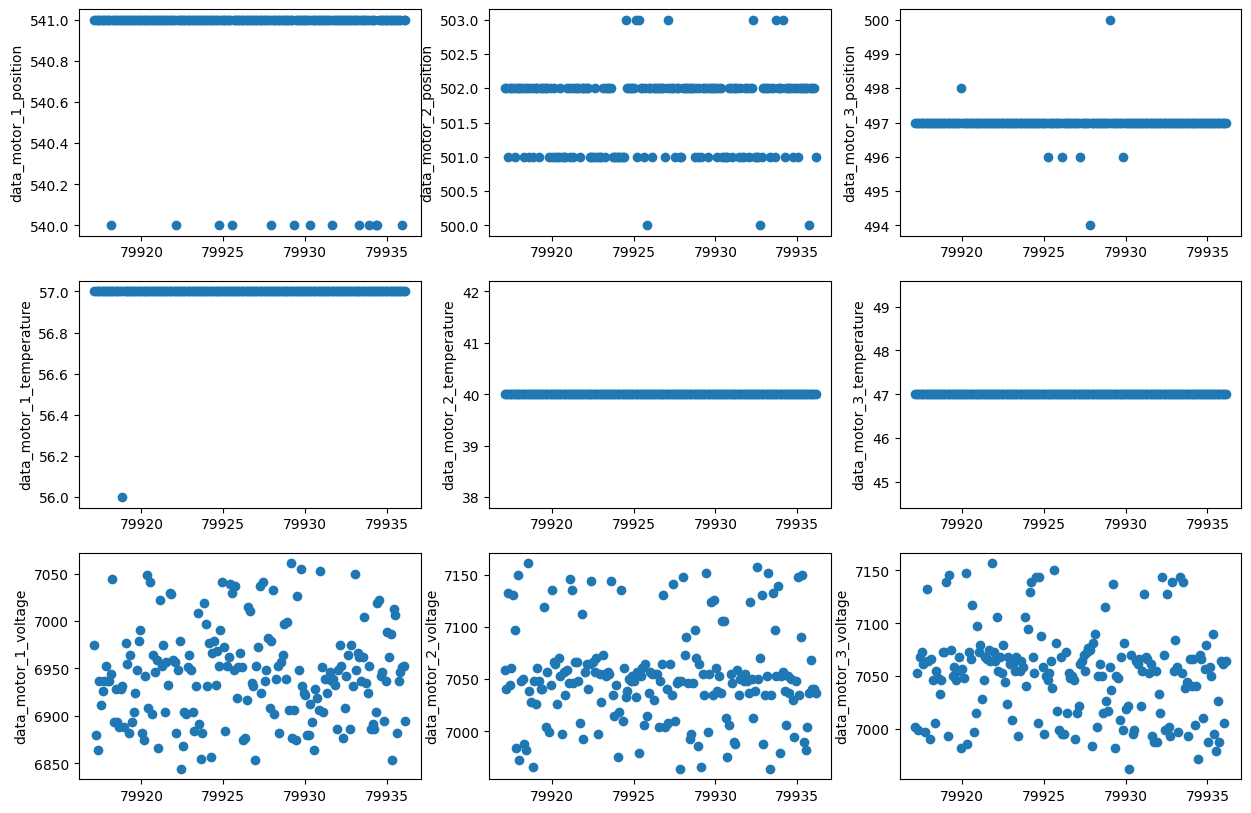

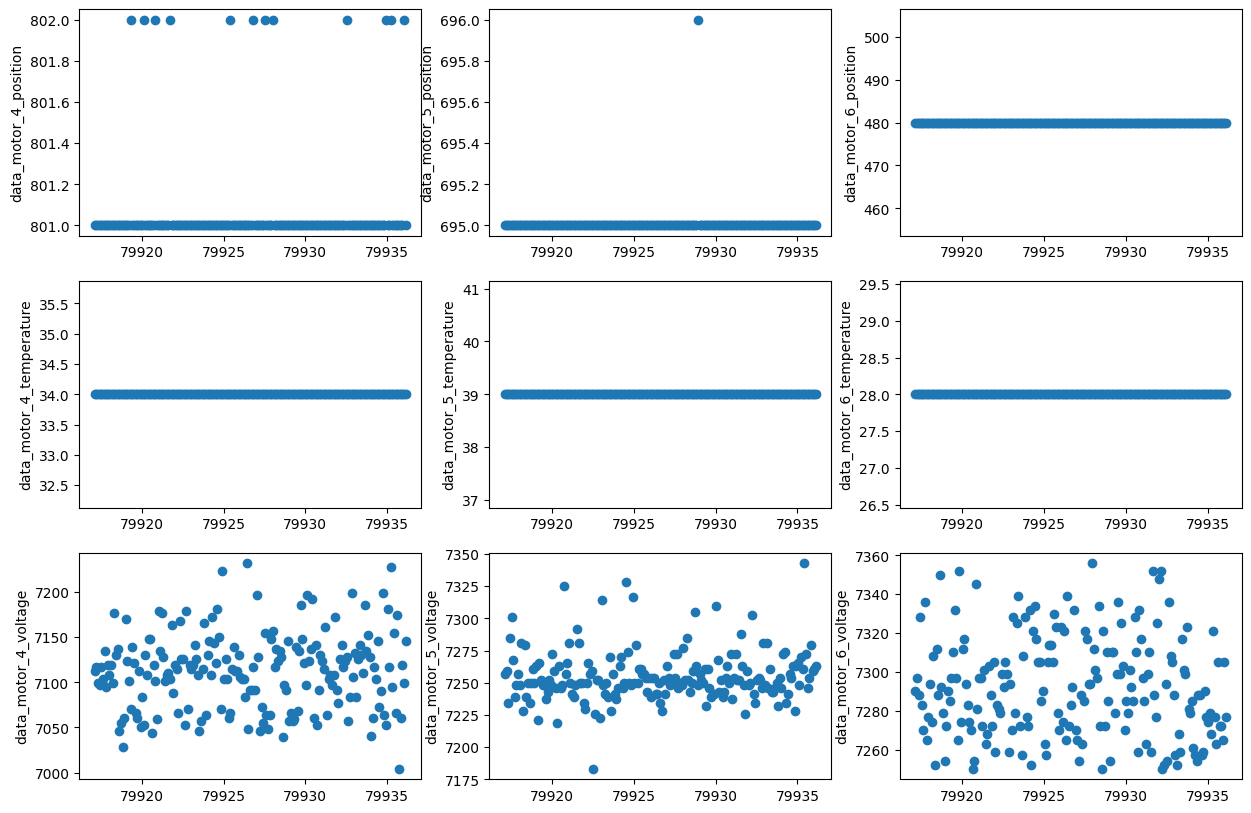

20240321_122650: 6    Try to move to pick up an item from second flo...
Name: Description, dtype: object



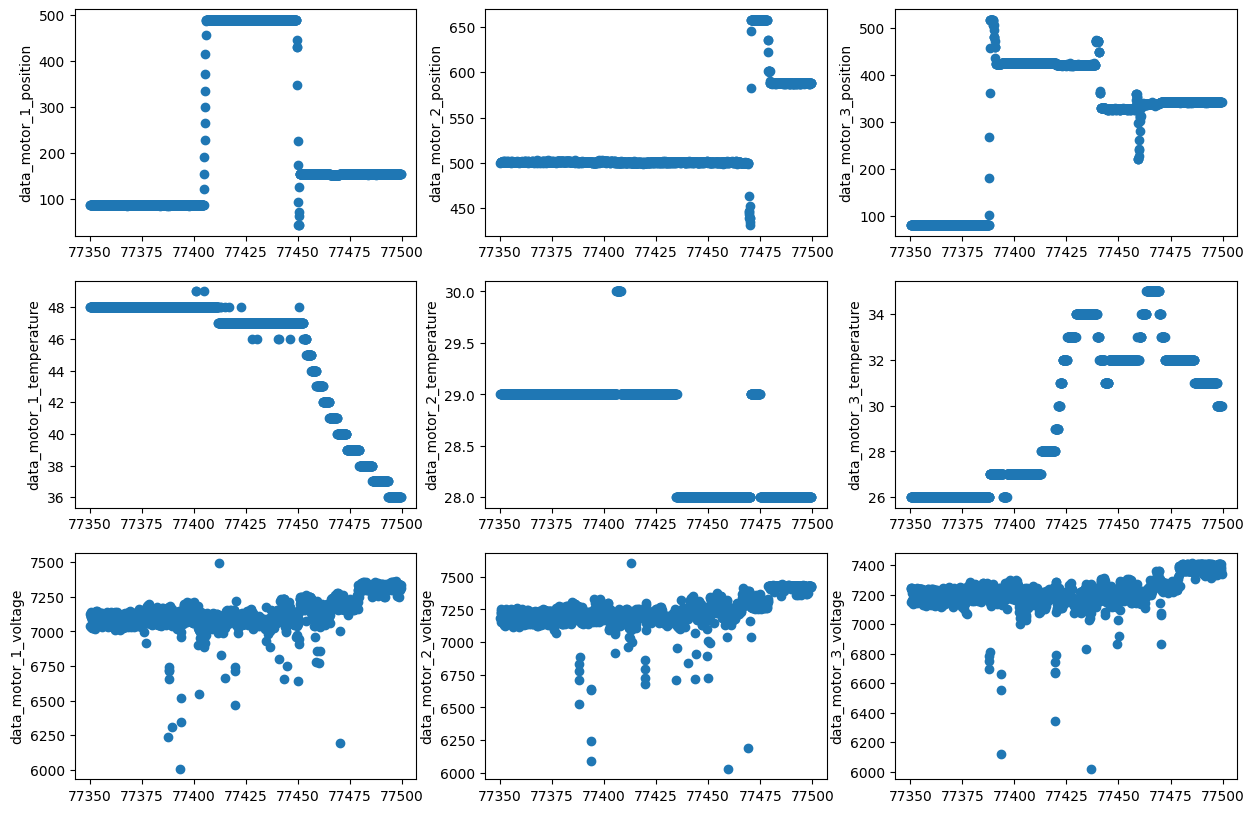

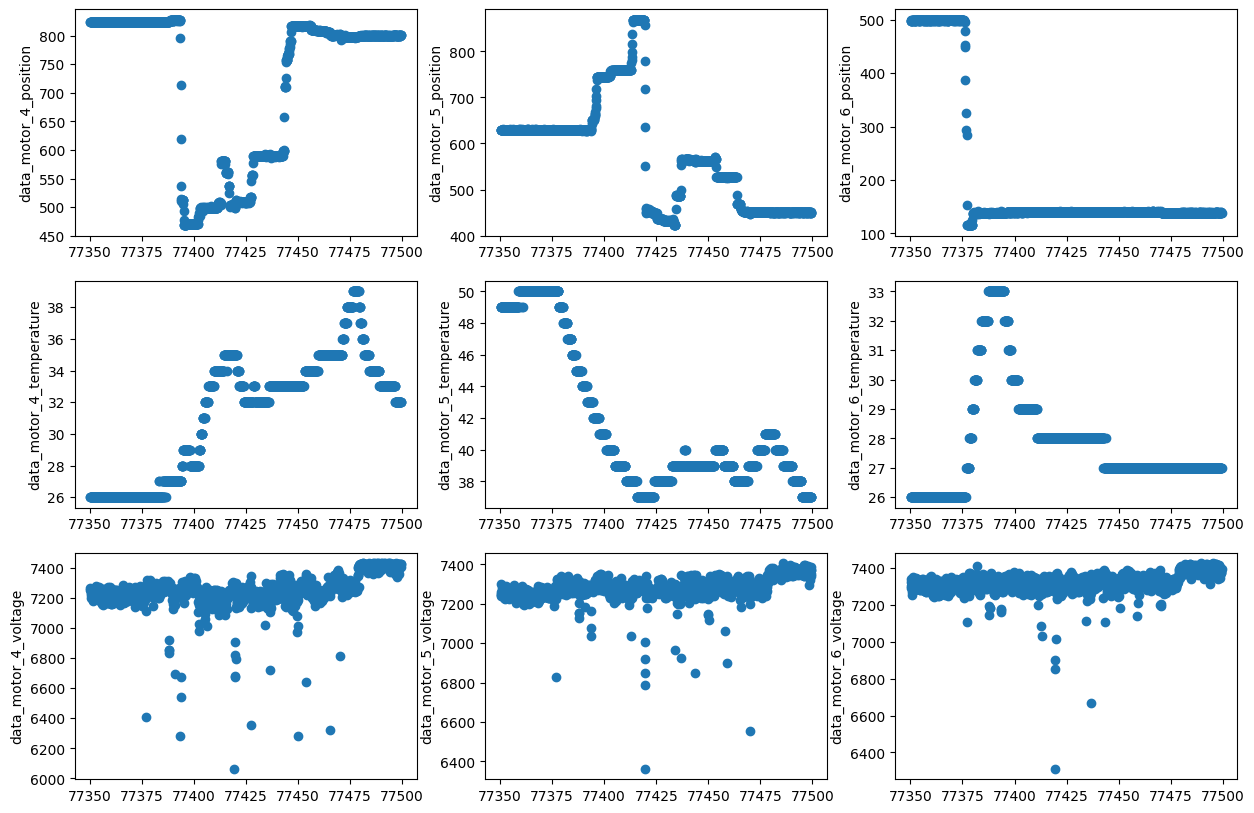

20240325_135213: 7    Robot not moving, just starting up.
Name: Description, dtype: object



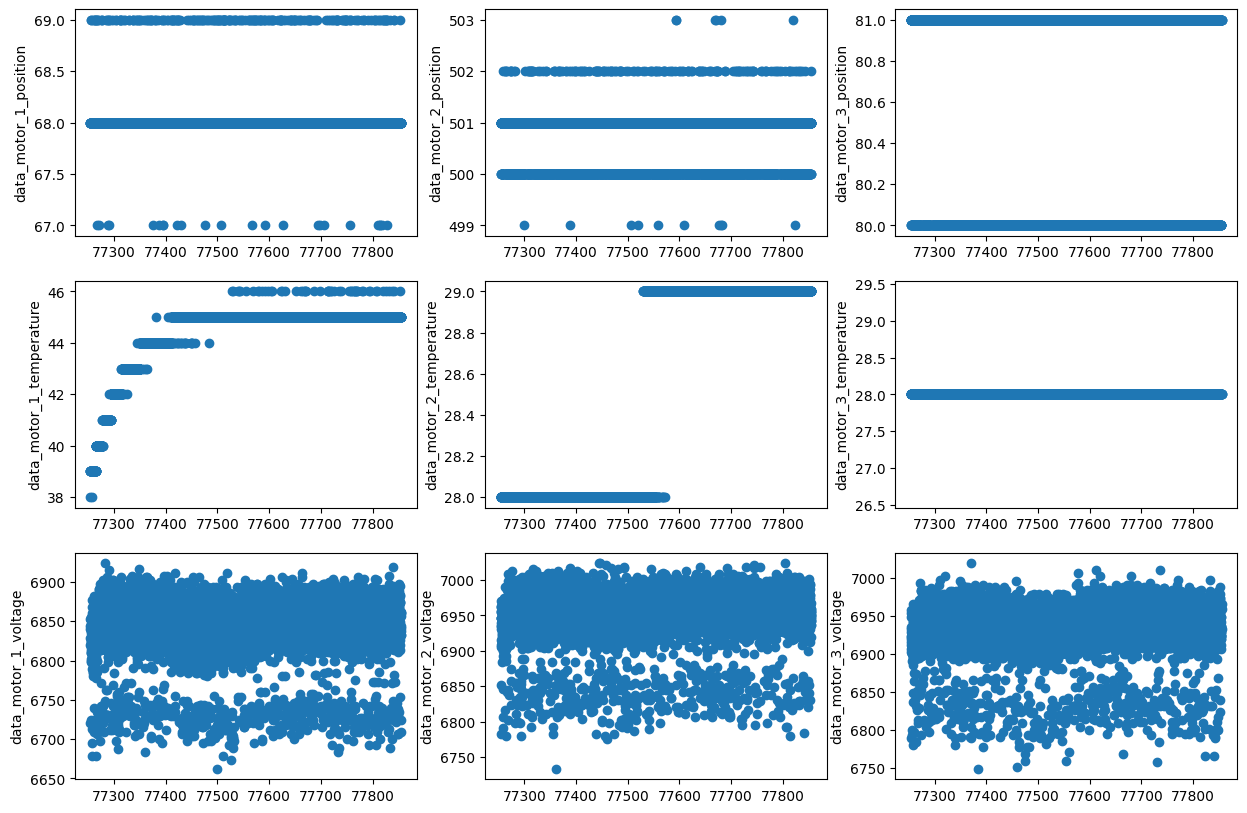

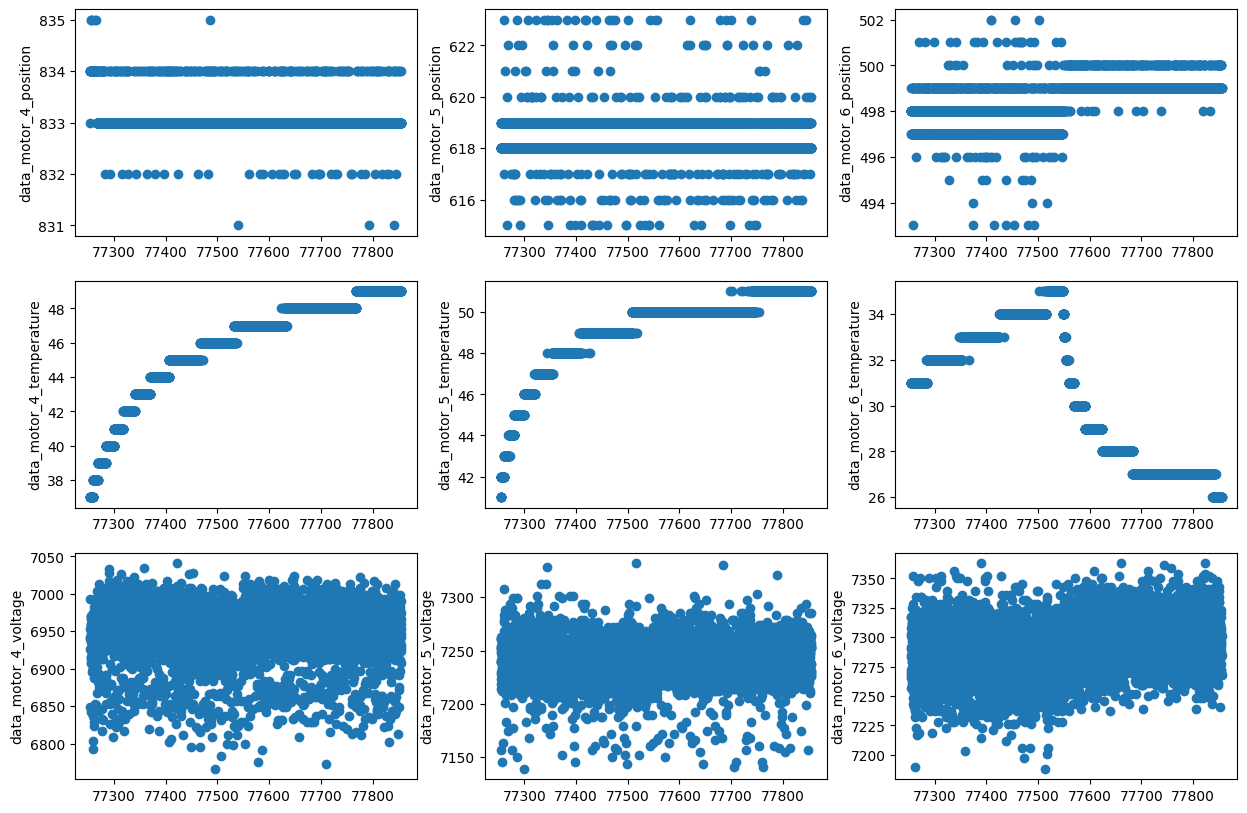

20240325_152902: 8    Not moving. Then perform a pick-up and place o...
Name: Description, dtype: object



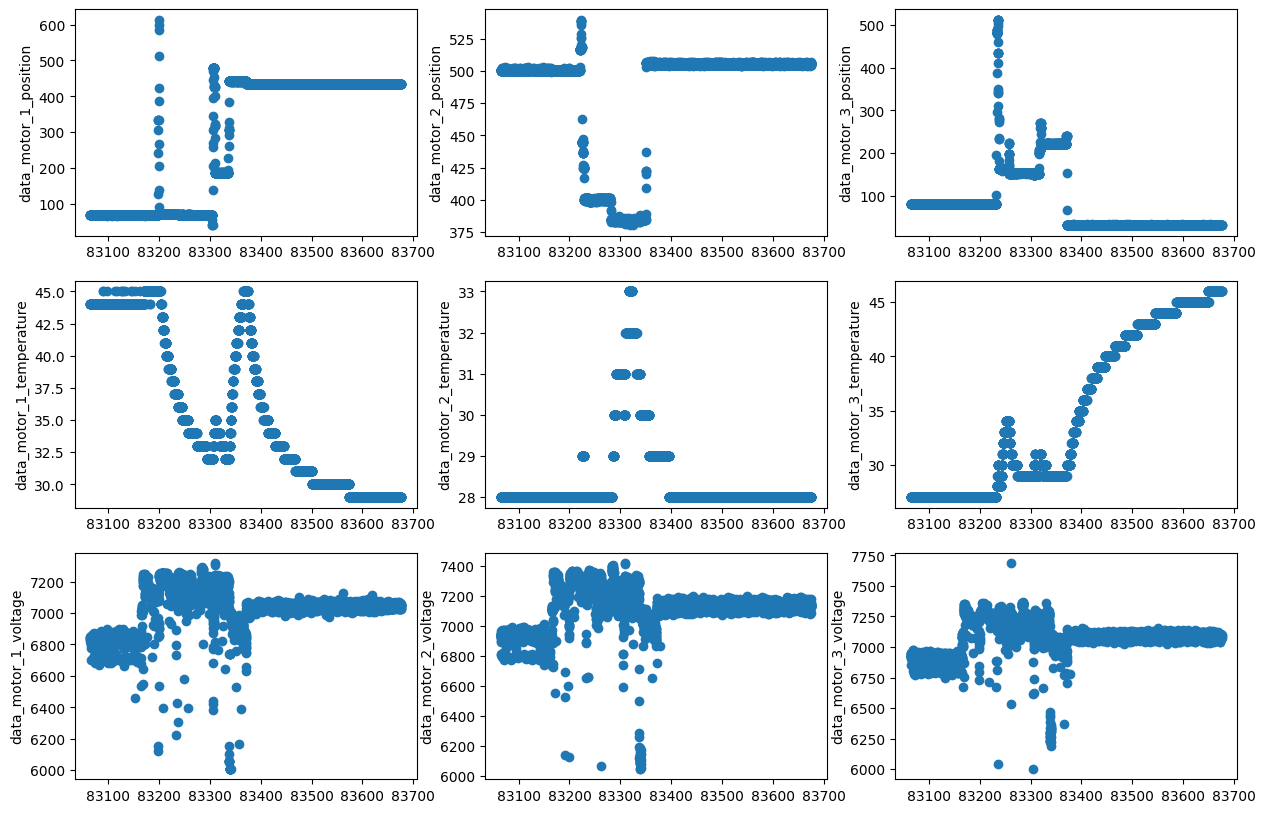

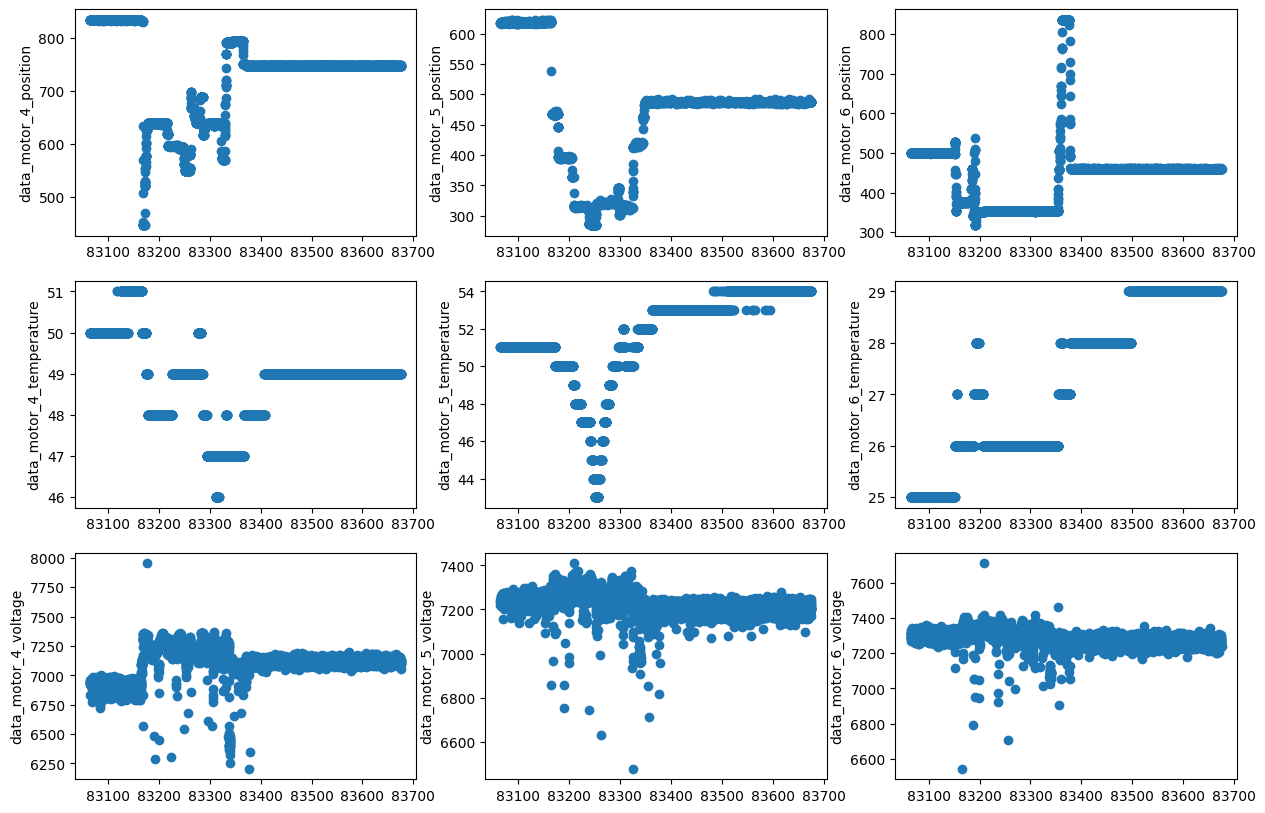

20240325_155003: 9    Starting position: Straigt. Perform two operat...
Name: Description, dtype: object



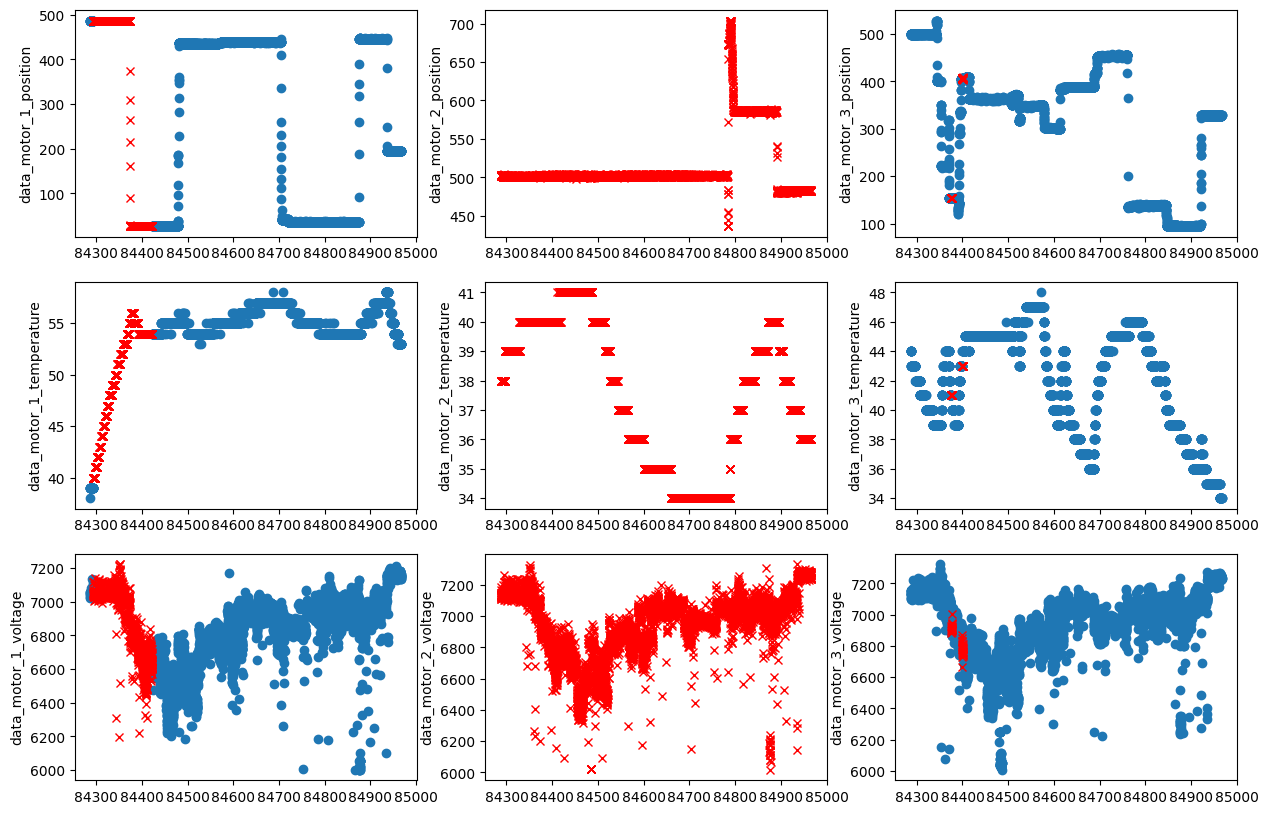

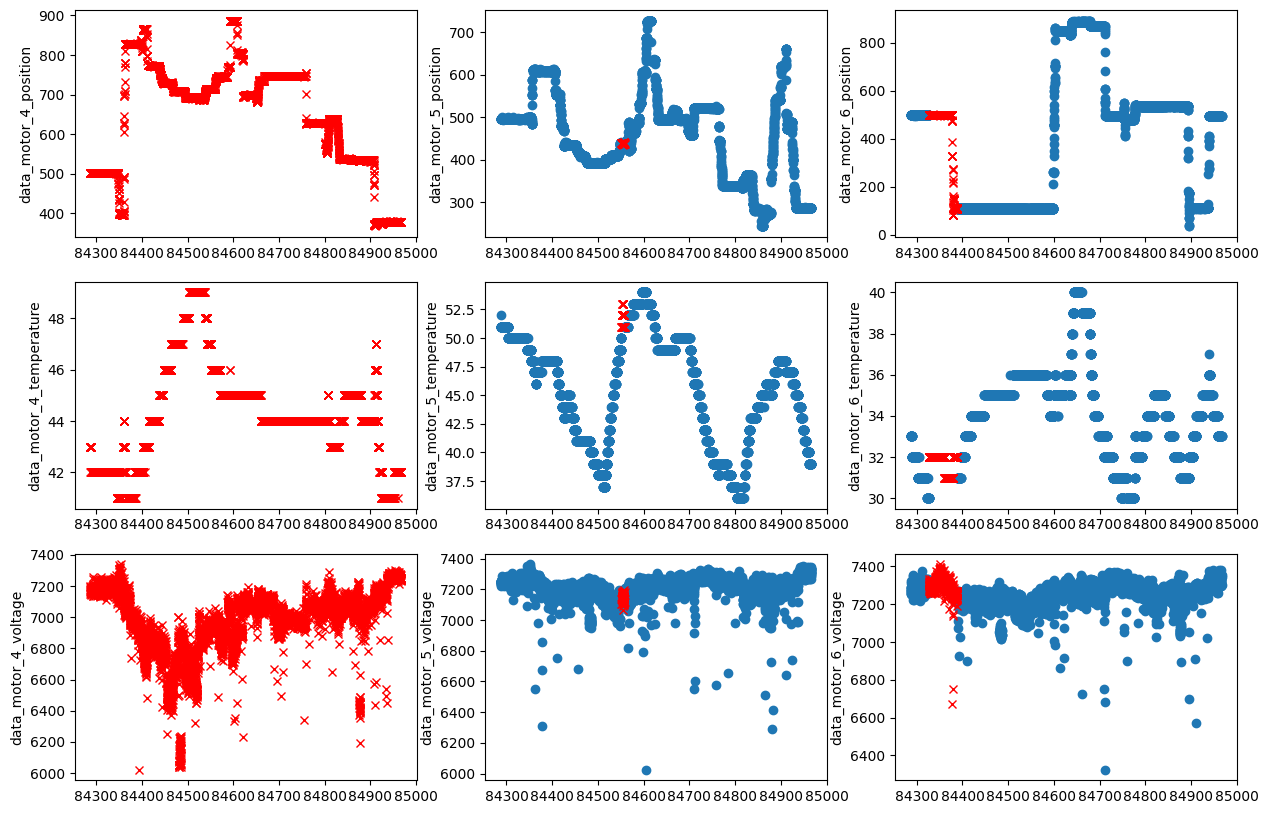

In [4]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 200, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers)

## Other possible preprocessing

You can define your own preprocessing function to considering more preprocessing approaches like moving average, low-pass/high-pass filers to further remove the noise in the original data.

## Correlation between varialbes

We can visualize the correlation between variables using a heatmap. Here, the purpose is to identify the features that are highly correlated to the response variable, and remove the features that are internally correlated. We have six response variable (we need one model per resposne variable).

<AxesSubplot:>

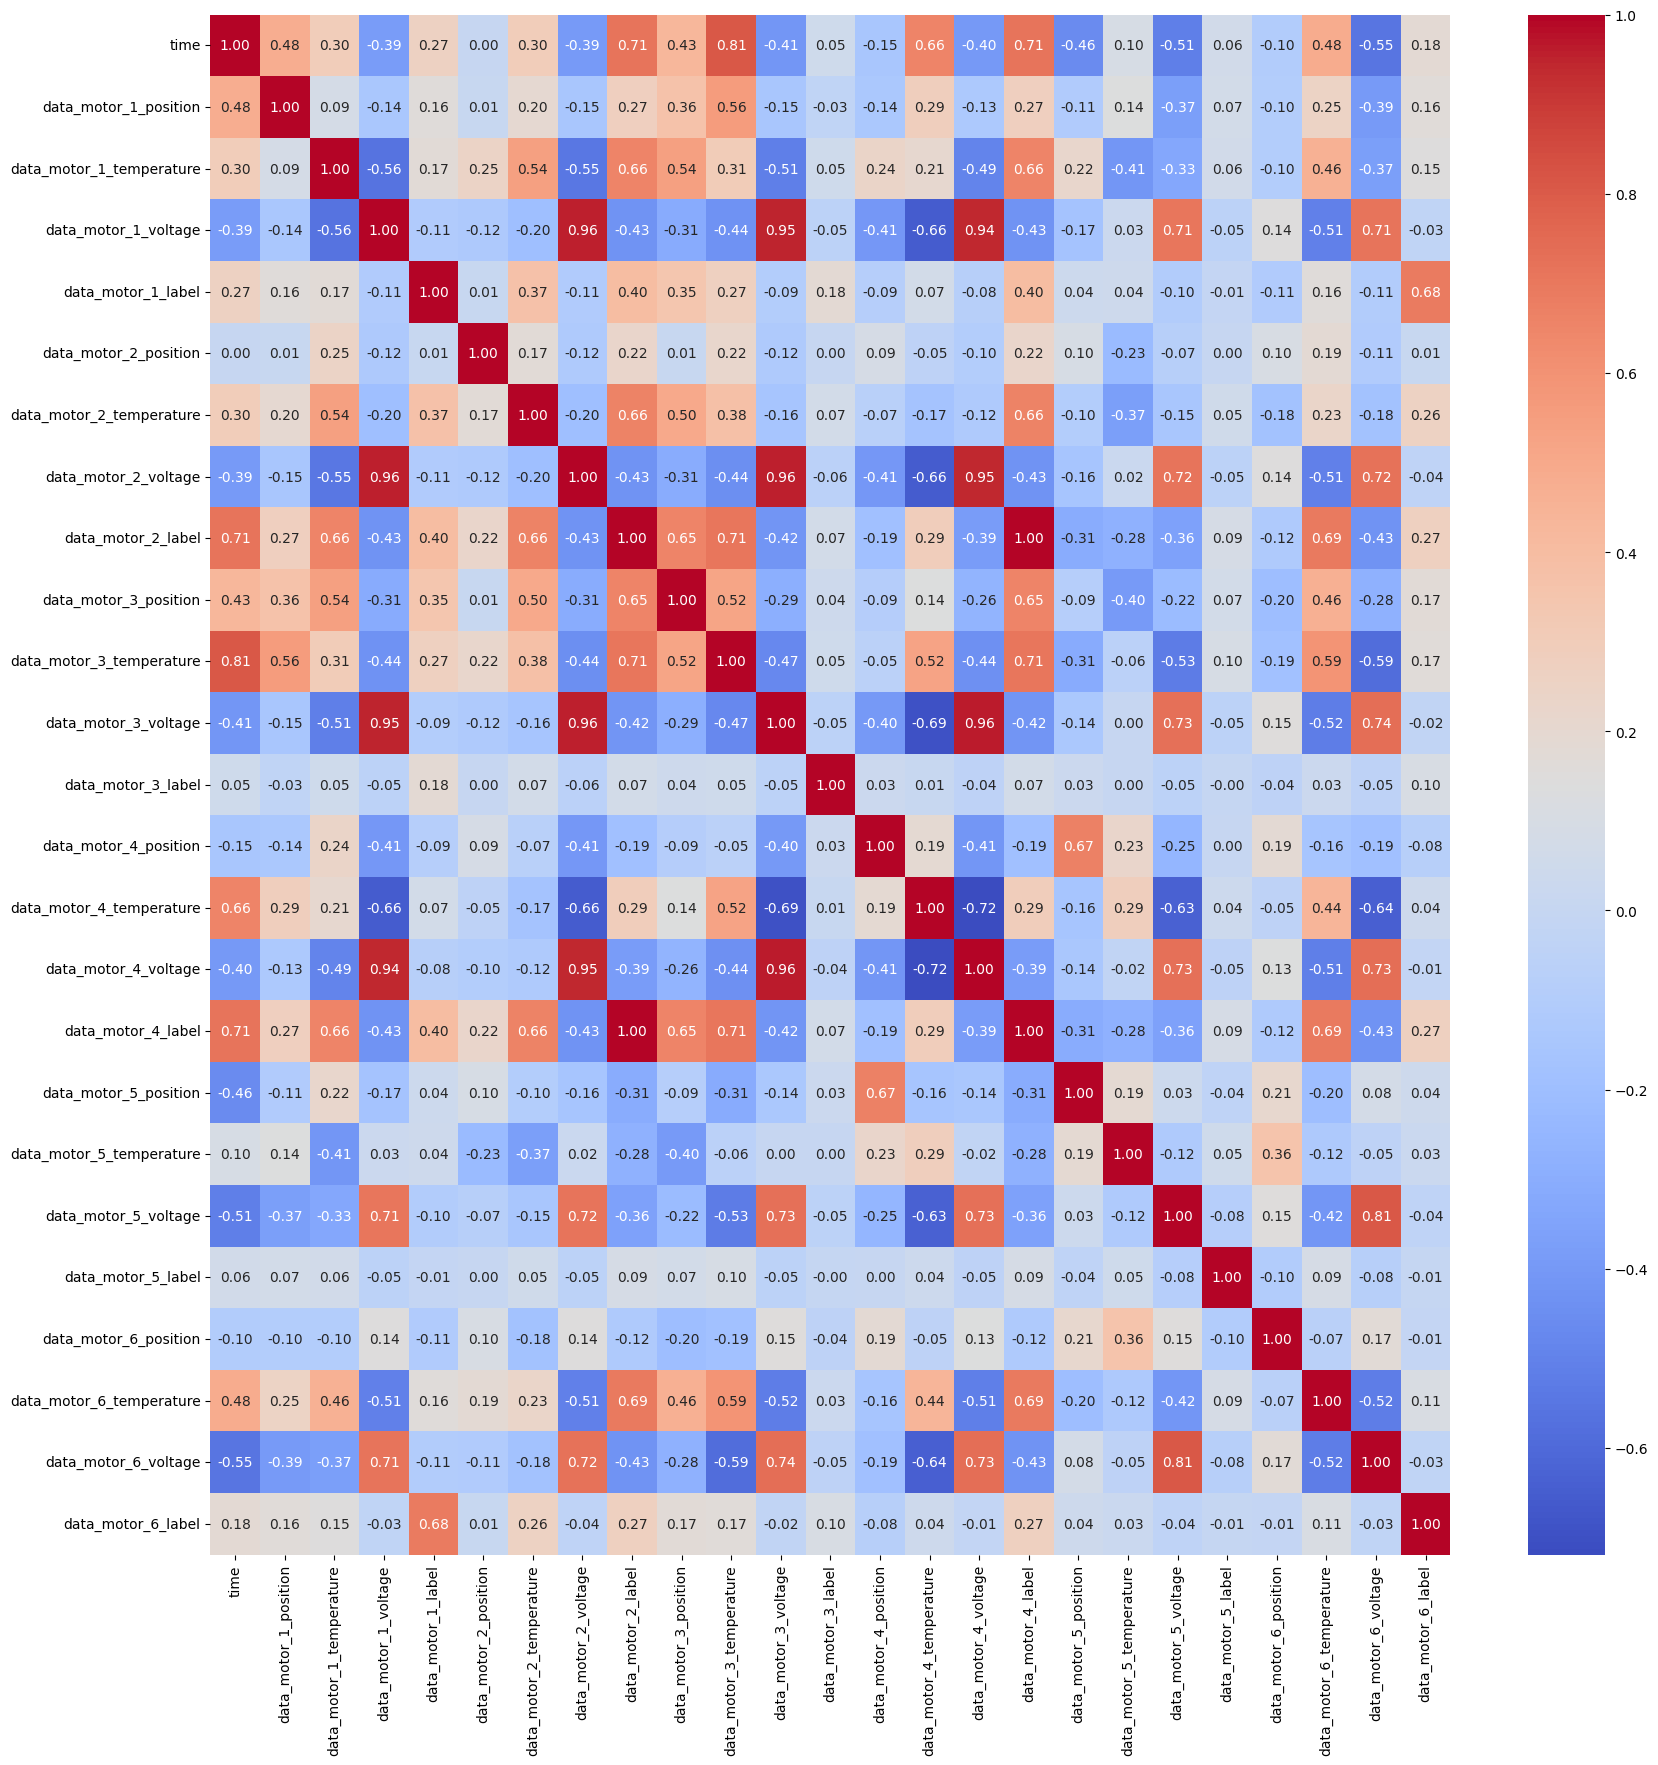

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# We keep only numerical variables. Remove the labels and it is not relavent in this case.
# df_data_processed = df_data.drop(columns=['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label',
#                                         'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label', 'test_condition'])
df_data_processed = df_data.drop(columns=['test_condition'])

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler to the data and transform the data
df_data_processed = pd.DataFrame(data=scaler.fit_transform(df_data_processed), columns=df_data_processed.columns)

# Compute correlation matrix
correlation_matrix = df_data_processed.corr()

# Plot correlation matrix using seaborn
plt.figure(figsize=(20, 20))  # Adjust width and height as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")